## Proyecto 3: Filtros
Laura Vargas - Isabela Trujillo

In [1]:
# Importaciones
! pip install PyWavelets
! pip install openpyxl
! pip install statsmodels

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import pywt

from google.colab import drive
from operator import length_hint
from ast import Pass

import scipy.stats as sis
import scipy.signal as signal
from scipy.signal import welch as pwelch

from statsmodels.nonparametric.smoothers_lowess import lowess


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 16.6 MB/s eta 0:00:00


## 1. Artículo

https://www.nature.com/articles/s41598-020-59821-7

Consultar y explicar los dos métodos de reducción de ruido usados en el artículo: Robust LOESS y Non Local Means (10%), mostrar cómo se podrían implementar en Python (5%)

### Robust LOESS

Es un tipo de filtro que se utiliza para eliminar la línea de base. Es un suavizador de regresión polinómica local. Se ajusta por medio de mínimos cuadrados ponderados, donde el mayor peso se da a los datos más cercanos al punto de estimación y el menor a los más alejados. Al ser robusta es que se asigna un peso cero a los datos que estén por fuera de seis desviaciones absolutas medias. Luego se resta la tendencia estimada por LOESS para eliminar el efecto de la desviación de la línea base [1].

Es una forma de estimar una superficie de regresión mediante una procedimiento de suavizado multivariante, ajustando una función de las variables independientes localmente y de forma móvil análoga a como se calcula una media móvil para una serie temporal [2].

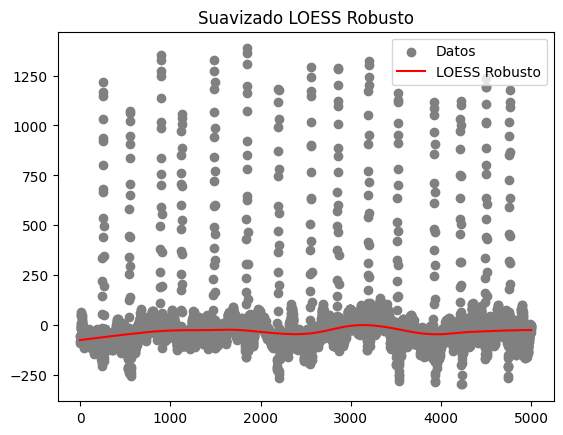

In [ ]:
# Se realiza después de convertir la derivacion_AFIB en array

x = np.arange(derivacion_AFIB.shape[1])
frac = 0.3  # Proporción de los datos usados para el suavizado
loess_robust = lowess(derivacion_AFIB[0], x, frac=frac, it=3)

# Visualizar los resultados
plt.scatter(x, derivacion_AFIB[0], label='Datos', color='gray')
plt.plot(loess_robust[:, 0], loess_robust[:, 1], label='LOESS Robusto', color='red')
plt.legend()
plt.title('Suavizado LOESS Robusto')
plt.show()

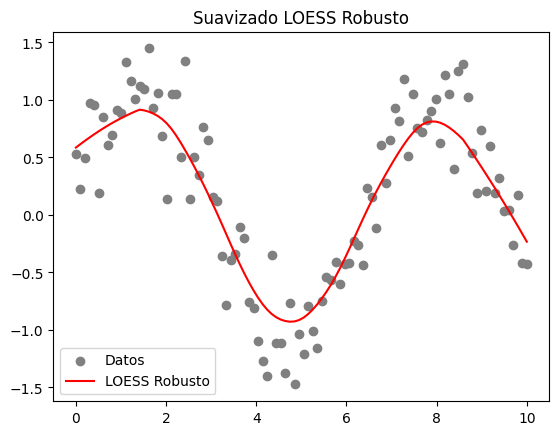

In [ ]:
# Datos de ejemplo
np.random.seed(0)
x = np.linspace(0, 10, 100)
y = np.sin(x) + np.random.normal(0, 0.3, x.shape)

# Aplicar LOESS robusto
frac = 0.3  # Proporción de los datos usados para el suavizado
loess_robust = lowess(y, x, frac=frac, it=3)

# Visualizar los resultados
plt.scatter(x, y, label='Datos', color='gray')
plt.plot(loess_robust[:, 0], loess_robust[:, 1], label='LOESS Robusto', color='red')
plt.legend()
plt.title('Suavizado LOESS Robusto')
plt.show()


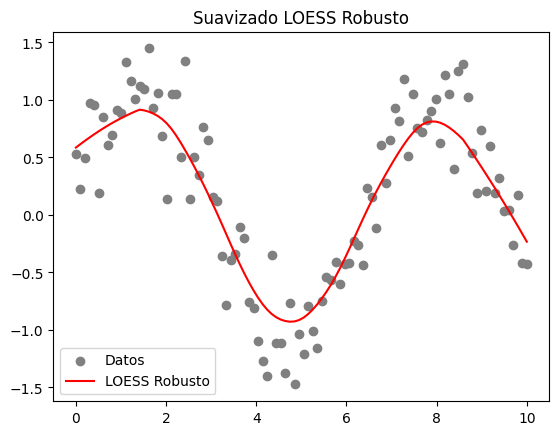

In [ ]:
!pip install statsmodels --upgrade

import statsmodels.api as sm

# Datos de ejemplo
np.random.seed(0)
x = np.linspace(0, 10, 100)
y = np.sin(x) + np.random.normal(0, 0.3, x.shape)

# Aplicar LOESS robusto con sm.nonparametric.lowess

frac = 0.3  # Proporción de los datos usados para el suavizado
loess_robust = sm.nonparametric.lowess(y, x, frac=frac, it=3, delta=0.0) # delta=0.0 is used for robust fitting

# Visualizar los resultados
plt.scatter(x, y, label='Datos', color='gray')
# lowess returns an array with the first column as the sorted x values and the second column as the fitted y values.
plt.plot(loess_robust[:, 0], loess_robust[:, 1], label='LOESS Robusto', color='red')
plt.legend()
plt.title('Suavizado LOESS Robusto')
plt.show()

### Non Local Means

El filtro de medias no locales (NLM) se utilizó para eliminar ruido restante luego de aplicar filtro pasa bajas de Butterworth.

Para una determinada longitud de datos de series temporales univariantes, NLM reconstruye los datos por medio de la media ponderada de todos los datos de la secuencia original. Los pesos se determinan por la medida de similitud del dato de la secuencia respecto a su índice de locación respectivo.

Para esta eliminación de ruido se tiene en cuenta el parámetro de control de suavidad y un parche local de muestras que contienen n muestras. Por lo tanto, en cada punto, el suavizado NLM toma información de todos los puntos que tienen patrones similares dentro del rango de búsqueda y la medida de similitud determina cuántos períodos se incluirán y promediarán.

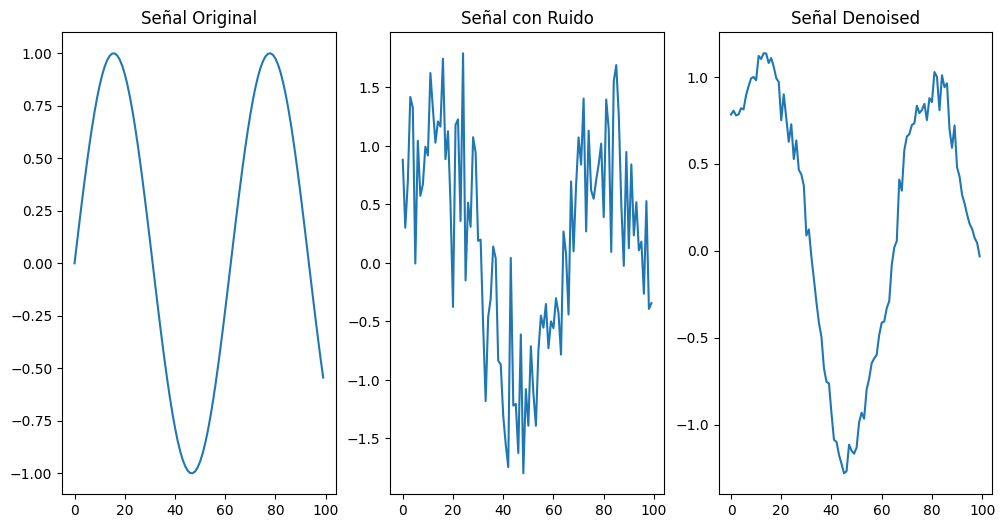

In [ ]:
# Se crea una función para el filtro NLM
# h -> Controla el grado de suavizado (A mayor valor, más sauvizado)
# parche -> Tamaño del parche utilizado para la comparación

def non_local_means(signal, h=1.0, parche=5):
    n = len(signal)
    denoised_signal = np.zeros(n) # Arreglo para almacenar los valores suavizados

    for i in range(n):
        weights = np.zeros(n) # Almacena el peso de cada punto de la señal
        # Para cada punto j, se calcula la distancia entre el valor de la señal en i y el valor en j
        for j in range(max(0, i - parche), min(n, i + parche + 1)):
            if j != i:
                # Calcular la similitud entre parches
                distance = np.abs(signal[i] - signal[j])
                weights[j] = np.exp(-distance / h) # Se calcula el peso del punto j con una función exponencial que disminuye con la distancia

        # Normalizar los pesos
        weights /= np.sum(weights)
        # Calcular el valor denoised, es la sumatoria de los valores de la señal original, usando los pesos
        denoised_signal[i] = np.sum(weights * signal)

    return denoised_signal

# Crear una señal de ejemplo con ruido
np.random.seed(0)
senal_original = np.sin(np.linspace(0, 10, 100))
senal_ruido = senal_original + np.random.normal(0, 0.5, senal_original.shape)

# Aplicar el filtro Non Local Means
senal_filtrada = non_local_means(senal_ruido, h=1.5, parche=5)

# Mostrar la señal original, la señal con ruido y la señal denoised
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title('Señal Original')
plt.plot(senal_original)
plt.subplot(1, 3, 2)
plt.title('Señal con Ruido')
plt.plot(senal_ruido)
plt.subplot(1, 3, 3)
plt.title('Señal Denoised')
plt.plot(senal_filtrada)
plt.show()

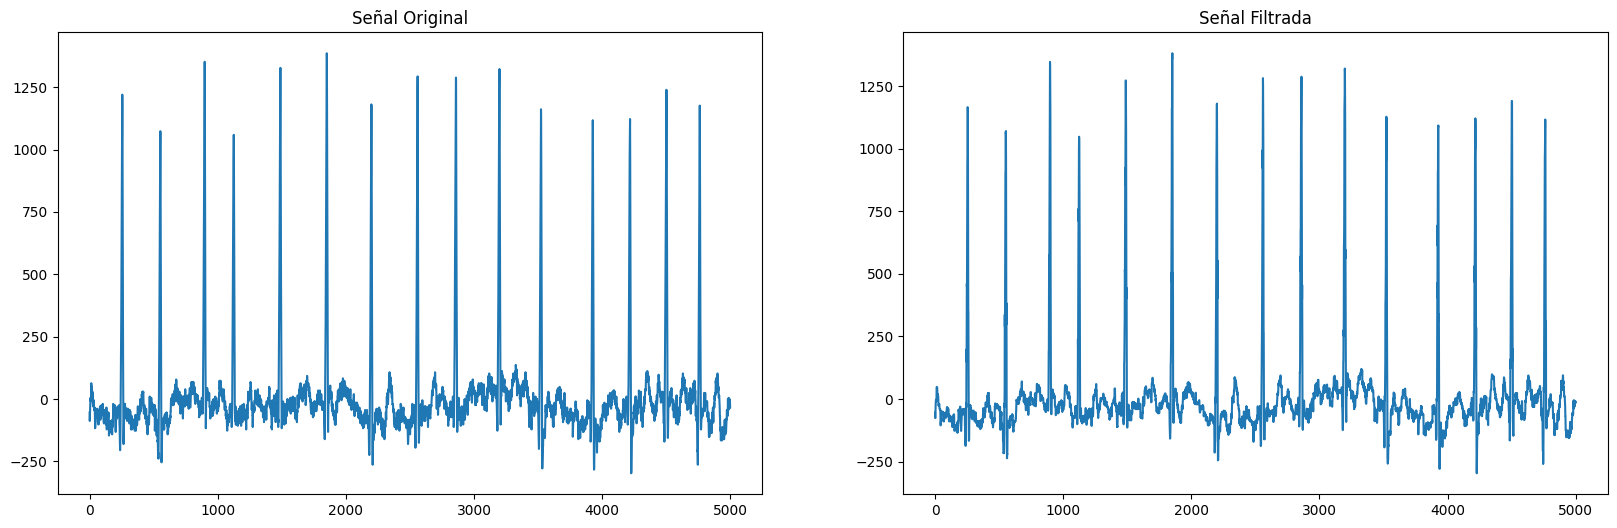

In [ ]:
AFIB_filtrada = non_local_means(derivacion_AFIB[0], h=10, parche=5)

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.title('Señal Original')
plt.plot(derivacion_AFIB[0])
plt.subplot(1, 2, 2)
plt.title('Señal Filtrada')
plt.plot(AFIB_filtrada)
plt.show()

## 2. De la base de datos extraer los registros que correspondan a bradicardia sinusal (SB Sinus Bradycardia) y fibrilación auricular (AFIB Atrial Fibrillation). De la derivación II

### Extracción

In [2]:
from google.colab import drive
#!pip install openpyxl
drive.mount('/content/drive') #force_remount=True
directorio_actual=os.getcwd()

df = pd.read_excel('/content/drive/MyDrive/ColabNotebooks/Biosenales/Diagnostics.xlsx')

AFIB=df[df['Rhythm'] == 'AFIB' ] #Encontrar los nombres de los archivos que corresponden a  la enfermedad Atrial Fibrillation (AFIB)
SB=df[df['Rhythm'] == 'SB' ]  #Encontrar los nombres de los archivos que corresponden a  la enfermedad Sinus Bradycardia (SB)

nombres_AFIB=AFIB['FileName'].tolist() # Forma una lista con lo que esta en FileName del AFIB
nombres_SB=SB['FileName'].tolist()
print(np.shape(nombres_AFIB))
print(np.shape(nombres_SB))

Mounted at /content/drive
(1780,)
(3889,)


In [3]:
!cp /content/drive/MyDrive/ColabNotebooks/Biosenales/Proyecto_3/ECGData.zip .
!unzip ECGData.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: ECGData/MUSE_20180112_133500_45000.csv  
  inflating: ECGData/MUSE_20180112_133502_57000.csv  
  inflating: ECGData/MUSE_20180112_133517_13000.csv  
  inflating: ECGData/MUSE_20180112_133520_30000.csv  
  inflating: ECGData/MUSE_20180112_133525_62000.csv  
  inflating: ECGData/MUSE_20180112_133534_74000.csv  
  inflating: ECGData/MUSE_20180112_133541_12000.csv  
  inflating: ECGData/MUSE_20180112_133542_15000.csv  
  inflating: ECGData/MUSE_20180112_133558_67000.csv  
  inflating: ECGData/MUSE_20180112_133642_18000.csv  
  inflating: ECGData/MUSE_20180112_133714_40000.csv  
  inflating: ECGData/MUSE_20180112_133734_35000.csv  
  inflating: ECGData/MUSE_20180112_133738_64000.csv  
  inflating: ECGData/MUSE_20180112_133746_02000.csv  
  inflating: ECGData/MUSE_20180112_133802_49000.csv  
  inflating: ECGData/MUSE_20180112_133816_89000.csv  
  inflating: ECGData/MUSE_20180112_133822_21000.csv  
  inflating: ECGData/

In [4]:
directorio_actual=os.getcwd()
archivos=os.listdir(directorio_actual+"/ECGData")

derivacion_AFIB=[]
derivacion_SB=[]

for i in archivos:
  if i[:-4] in nombres_AFIB:
    datos = pd.read_csv(directorio_actual+"/ECGData/"+i,delimiter=',')
    derivacion_AFIB.append(datos['II'])
  if i[:-4] in nombres_SB:
    datos = pd.read_csv(directorio_actual+"/ECGData/"+i,delimiter=',')
    derivacion_SB.append(datos['II'])

In [5]:
derivacion_AFIB=np.array(derivacion_AFIB)
derivacion_SB=np.array(derivacion_SB)
print(np.shape(derivacion_AFIB))
print(np.shape(derivacion_SB))

(1780, 5000)
(3889, 5000)


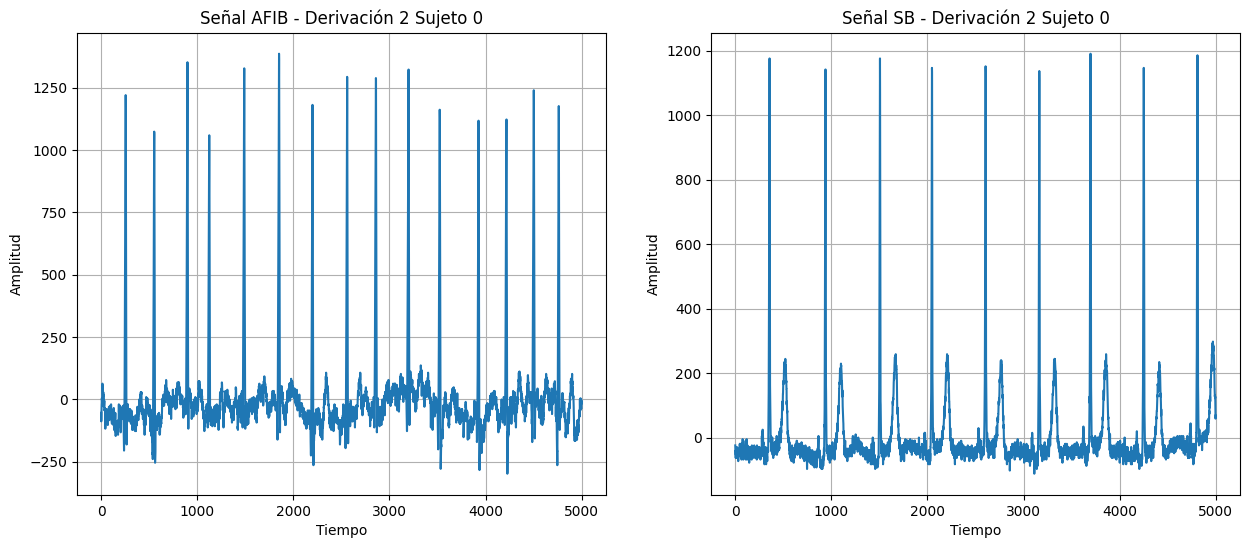

In [6]:
#Señales originales
plt.figure(figsize=(15, 6))
plt.subplot(1,2,2)
plt.plot(derivacion_SB[0])
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Señal SB - Derivación 2 Sujeto 0')
plt.grid(True)

plt.subplot(1,2,1)
plt.plot(derivacion_AFIB[0])
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Señal AFIB - Derivación 2 Sujeto 0')
plt.grid(True)

## 3. Consultar que otros tipos de señales wavelet se pueden usar para el análisis de señales ECG y adaptar el código del filtro wavelet que se entrega en el curso de acuerdo a la consulta (10%)

El código entregado venía con la familia definida como "db6". Se cambió a "db4".
La elección de la familia wavelet para la señal ECG y su nivel de descomposición radica en la forma y biología de la señal ECG auténtica [3], se encontró que se utiliza la familia Symlet [4], Daubechie, Bior [5], Coif, donde la familia Daubechie da los mejores resultados entre todas las familias de wavelets [3].

Se entiende que la familia Daubechie sea la que mejor resultados da debido a que es una familia no simétrica tal como la ECG biológica y su forma de onda es muy parecida al complejo PQRST [6].

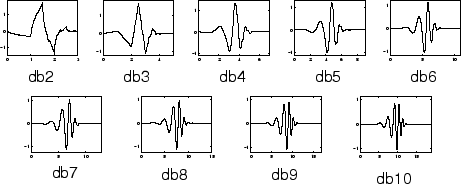

Tomado de: “Introduction to Wavelet Families - MATLAB & Simulink - MathWorks América Latina”. Consultado: el 4 de noviembre de 2024. [En línea]. Disponible en: https://la.mathworks.com/help/wavelet/gs/introduction-to-the-wavelet-families.html


Debido a la relación entre la descomposición del nivel y el nivel de ruido, el nivel de descomposición adecuado para un nivel de ruido alto es 7-8, mientras que para un nivel de ruido bajo, es 3-4. [7]

El filtro original era:

In [7]:
#Funciones
def wnoisest(coeff):
    stdc = np.zeros((len(coeff),1));
    for i in range(0,len(coeff)):
        stdc[i] = (np.median(np.absolute(coeff[i])))/0.6745; #halla σ
    return stdc;

def threshold(coeff):
    Num_samples = 0;
    for i in range(0,len(coeff)):
        Num_samples = Num_samples + coeff[i].shape[0];

    thr = np.sqrt(2*(np.log(Num_samples))) # Halla Lambda
    return thr

def wthresh(coeff):
    y   = list();
    s = wnoisest(coeff);
    #print(s)
    thr = threshold(coeff)
    #print(thr)
    for i in range(0,len(coeff)):
        y.append(np.multiply(coeff[i],np.abs(coeff[i])>(thr*s[i]))); #Aplica el umbral y si es menor lo pone en 0 (umbralización dura)
    return thr,s,y;

In [8]:
data=np.squeeze(derivacion_AFIB[15])
LL = int(np.floor(np.log2(data.shape[0])));#Halla el nivel

data_wavelet = pywt.wavedec( data, 'db6', level=8 ); #Utilza db6 con 8 niveles (aplica wavelet - descompone)

details = data_wavelet[1:] #Detalles

thr, s, details_t = wthresh(details);

In [9]:
# Reconstrucción de la señal filtrada
coeff = list()
coeff.append(data_wavelet[0])

for i in range(len(details_t)):
  coeff.append(details_t[i])

Text(0, 0.5, 'Amplitud')

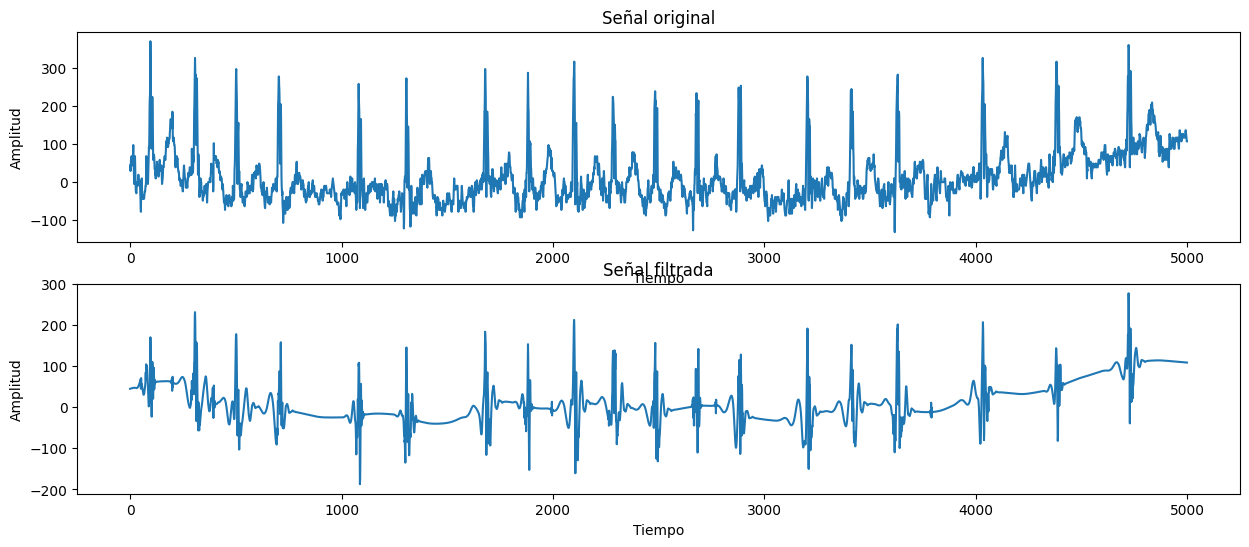

In [10]:
plt.figure(figsize=(15, 6))
plt.subplot( 2,1,1 )
plt.plot(data)
plt.title('Señal original')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')

x_rec = pywt.waverec( coeff, 'db6');
x_rec = x_rec[0:data.shape[0]];
plt.subplot( 2,1,2 )
plt.plot(x_rec)
plt.title('Señal filtrada')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')

### Wavelet Modificado

In [11]:
def wavelet_n(senal):
  senal_reconstruida=list()
  for data in senal:
    LL = int(np.floor(np.log2(data.shape[0])));#Halla el nivel

    data_wavelet = pywt.wavedec( data, 'db4', level=8 );

    details = data_wavelet[1:] #Detalles

    thr, s, details_t = wthresh(details);

    # Reconstrucción de la señal filtrada
    coeff = list()
    coeff.append(data_wavelet[0])

    for i in range(len(details_t)):
      coeff.append(details_t[i])

    x_rec = pywt.waverec( coeff, 'db4');
    x_rec = x_rec[0:data.shape[0]];
    senal_reconstruida.append(x_rec)
  return senal_reconstruida


## 4. Escoger 10 señales al azar y aplicar un flujo de procesamiento que conste de:

In [12]:
#10 señales para los flujos
datos_AFIB=derivacion_AFIB[:10,:]
datos_SB=derivacion_SB[:10,:]

Fs=500 #Según la fuente de la base de datos
n = np.arange(0,10,1/Fs) # tiempo


### **Flujo 1**

* Filtro pasa-altas usando filtro IIR a 0.5 Hz. Justificar la elección de parámetros

fs=500 Hz dado por la fuente de los datos ECG

fc= 0.5 Hz ya que se necesita que no se pierda el pico de máxima potencia que usualmente se presenta en frecuencias alrededor de 1 Hz (Teniendo en cuenta también los resultados del proyecto anterior)

El tipo de filtro IIR utilizado fue Chebyshev II como ftype="cheby2" debido a que permite utilizar ordenes bajos y obtener buena relación señal/ruido (SNR) [8]. Además de mantener esta relación estable a ordenes mayores[8].

El parámetro de atenuación mínima (rs) que requiere este tipo de filtro se definió a partir de la literatura encontrada pues 40 Hz, podría atenuar de forma evidente los complejos QRS y suavizar las pequeñas muescas por lo que se optó por un valor menor [9] [10].

rs = 30 dB   


* Filtro wavelet modificado del punto 3
* Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y de por qué usar IIR y no FIR

Se escogió diseño de filtro tipo FIR debido a que no presenta distorsión en fase, por lo que se preserva la integridad de la señal.

Para el método de ventanas se encontró que hay una alta relación señal/ruido SNR para señal ECG con la ventana rectangular, correspondiendo al parámetro "boxcar" con un orden de 6 siendo mayor incluso de los filtros IIR estudiados [9].

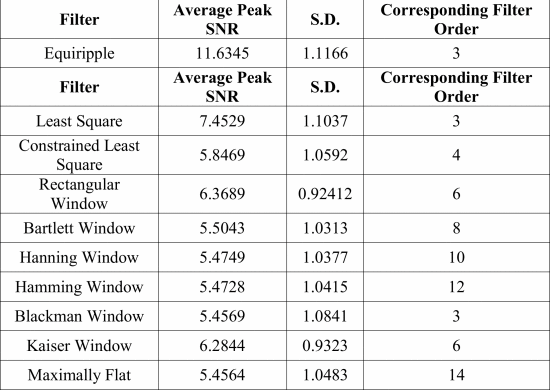

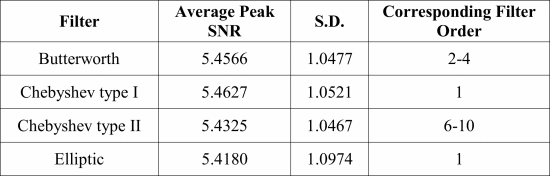

Imagenes tomadas de: [9]

#### Filtro pasa-altas usando filtro IIR a 0.5 Hz

In [13]:
def pasa_altas(senal,orden,Fs,rs,fc):
  nyquist = Fs/2 # frecuencia de nyquist
  wn = fc/nyquist #frecuencia de corte normalizada respecto nyquist
  #diseño del filtro
  numerator_h, denominator_h = signal.iirfilter(orden+1,wn,rs=rs, btype = 'highpass',ftype='cheby2')

  #AFIB
  pasa_altas=list()

  for i in senal:
    y_f= signal.filtfilt(b=numerator_h,a=denominator_h,x=i) # aplicación del filtro
    pasa_altas.append(y_f)
  return pasa_altas

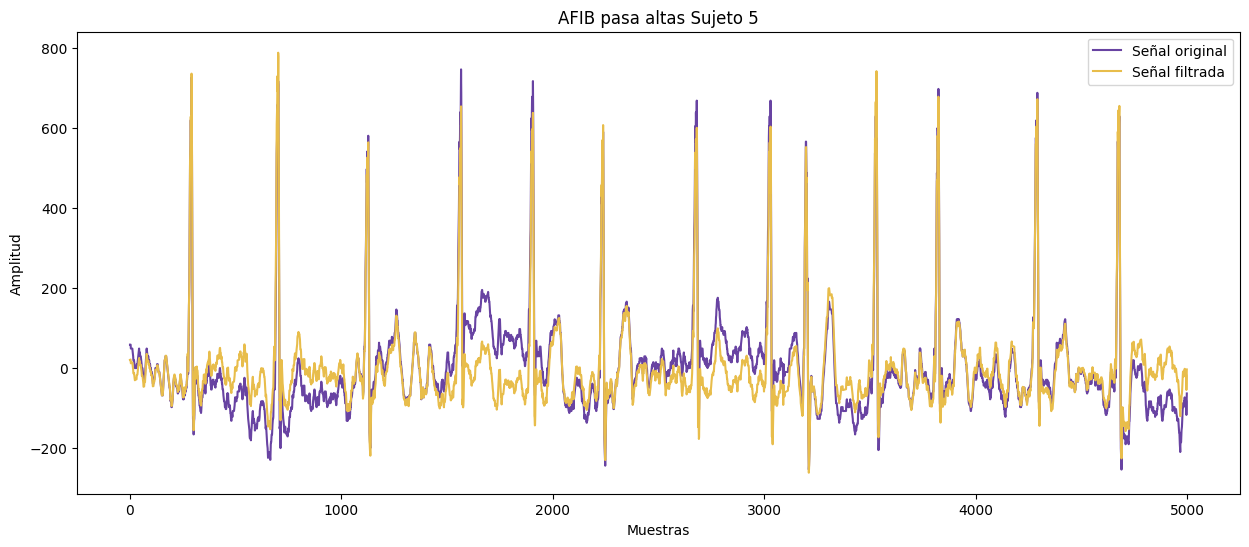

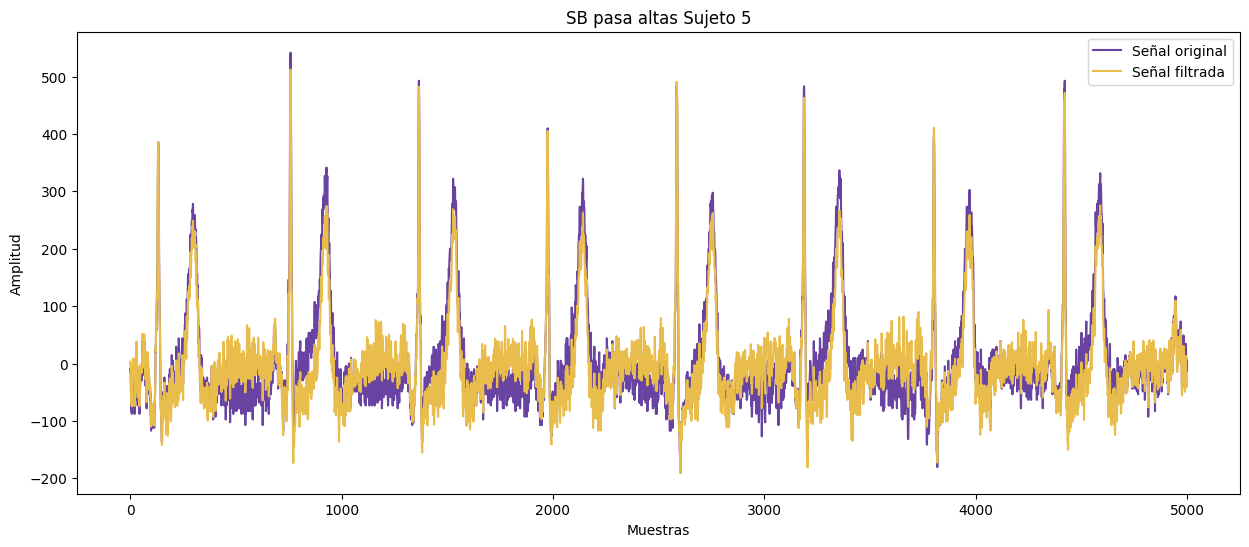

In [14]:
pasa_altas_AFIB=pasa_altas(datos_AFIB,2,Fs,30,0.5)
pasa_altas_SB=pasa_altas(datos_SB,2,Fs,30,0.5)

sujeto=5
plt.figure(figsize=(15, 6))
plt.plot(datos_AFIB[sujeto],label='Señal original',color='#6843A2')
plt.title(f'AFIB pasa altas Sujeto {sujeto}')
plt.legend()
plt.plot(pasa_altas_AFIB[sujeto],label='Señal filtrada',color='#E8BD4B')
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()

plt.figure(figsize=(15, 6))
plt.plot(datos_SB[sujeto],label='Señal original',color='#6843A2')
plt.title(f'SB pasa altas Sujeto {sujeto}')
plt.legend()
plt.plot(pasa_altas_SB[sujeto],label='Señal filtrada',color='#E8BD4B')
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()

#### Filtro wavelet modificado del punto 3

Text(0, 0.5, 'Amplitud')

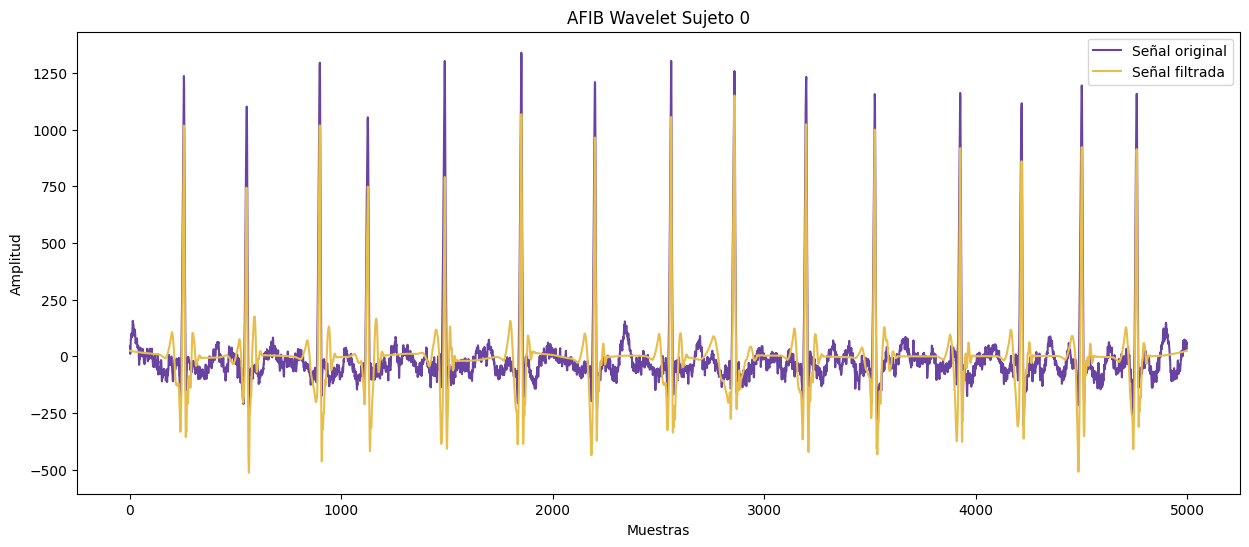

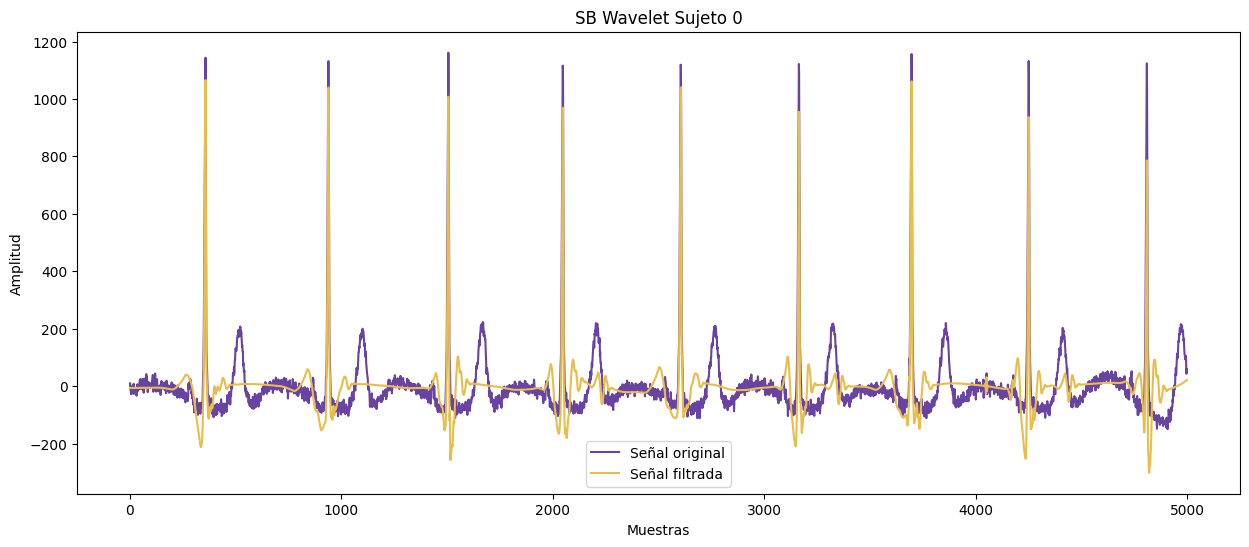

In [15]:
senal_reconstruida_AFIB=wavelet_n(pasa_altas_AFIB)
senal_reconstruida_SB=wavelet_n(pasa_altas_SB)

sujeto=0
plt.figure(figsize=(15, 6))
plt.plot(pasa_altas_AFIB[sujeto],label='Señal original',color='#6843A2')
plt.title(f'AFIB Wavelet Sujeto {sujeto}')
plt.legend()
plt.plot(senal_reconstruida_AFIB[sujeto],label='Señal filtrada',color='#E8BD4B')
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Amplitud')


plt.figure(figsize=(15, 6))
plt.plot(pasa_altas_SB[sujeto],label='Señal original',color='#6843A2')
plt.title(f'SB Wavelet Sujeto {sujeto}')
plt.legend()
plt.plot(senal_reconstruida_SB[sujeto],label='Señal filtrada',color='#E8BD4B')
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Amplitud')

#### Filtrado pasabajas 50 Hz.

In [16]:
def pasa_bajas_n(senal,orden,Fs,fc):
  nyquist = Fs/2 # frecuencia de nyquist
  wn = fc/nyquist #frecuencia de corte normalizada respecto nyquist
  #numerator_l, denominator_l = signal.iirfilter(orden+1,wn,rs=30, btype = 'lowpass',ftype='cheby2')
  lowpass = signal.firwin(orden+1,wn, pass_zero = 'lowpass',window='boxcar') #filtro
  pasa_bajas=list()
  for i in senal:
    #y_f = signal.filtfilt(b=numerator_l,a=denominator_l,x=i) # aplicación del filtro
    y_f = signal.filtfilt(b=lowpass,a=1,x=i) # aplicación del filtro
    pasa_bajas.append(y_f)
  return pasa_bajas

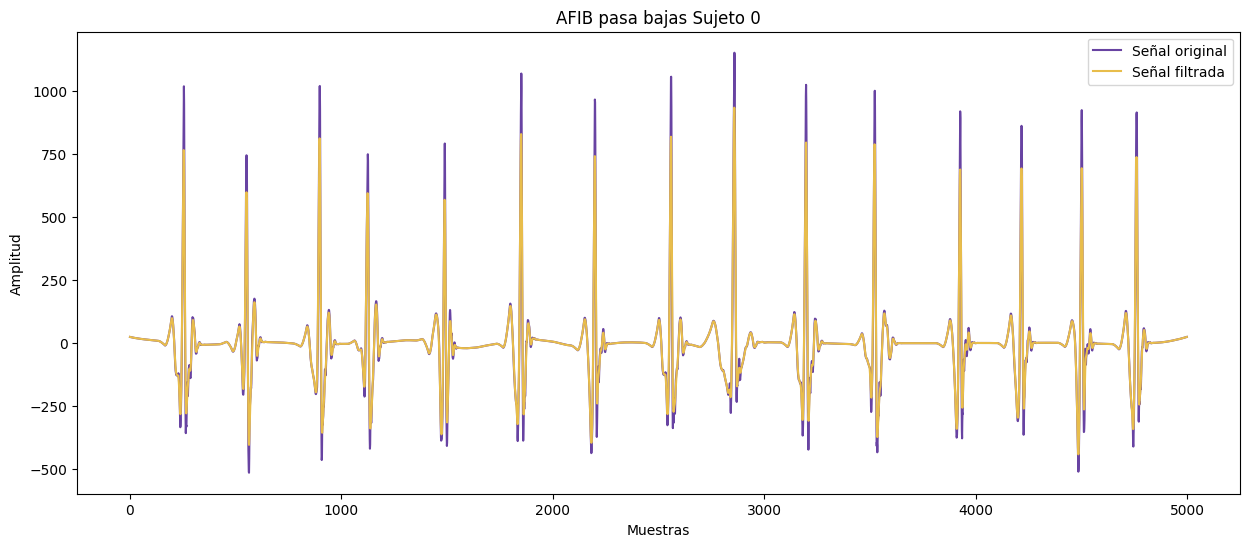

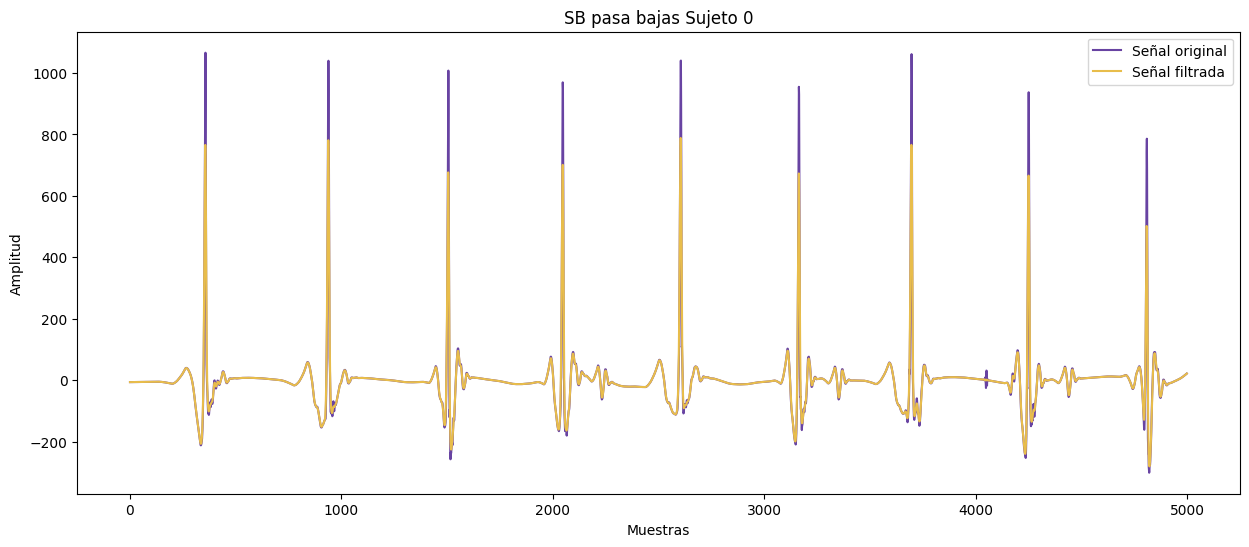

In [17]:
pasa_bajas_AFIB_flujo1=pasa_bajas_n(senal_reconstruida_AFIB,6,Fs,50)
pasa_bajas_SB_flujo1=pasa_bajas_n(senal_reconstruida_SB,6,Fs,50)

sujeto=0
plt.figure(figsize=(15, 6))
plt.plot(senal_reconstruida_AFIB[sujeto],label='Señal original',color='#6843A2')
plt.title(f'AFIB pasa bajas Sujeto {sujeto}')
plt.legend()
plt.plot(pasa_bajas_AFIB_flujo1[sujeto],label='Señal filtrada',color='#E8BD4B')
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()

plt.figure(figsize=(15, 6))
plt.plot(senal_reconstruida_SB[sujeto],label='Señal original',color='#6843A2')
plt.title(f'SB pasa bajas Sujeto {sujeto}')
plt.legend()
plt.plot(pasa_bajas_SB_flujo1[sujeto],label='Señal filtrada',color='#E8BD4B')
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()

### **Flujo 2**
* Detrend
* Filtro wavelet modificado del punto 3
* Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR.   
En este caso, se empleó los mismo parámetros que en el filtro pasabajas del Flujo 1

#### Detrend

In [18]:
def detrend_n(senal):
  detrend=[]
  for i in senal:
    A=signal.detrend(i)
    detrend.append(A)

  detrend=np.array(detrend)
  return detrend

In [19]:
detrend_AFIB_f2=detrend_n(datos_AFIB)
detrend_SB_f2=detrend_n(datos_SB)

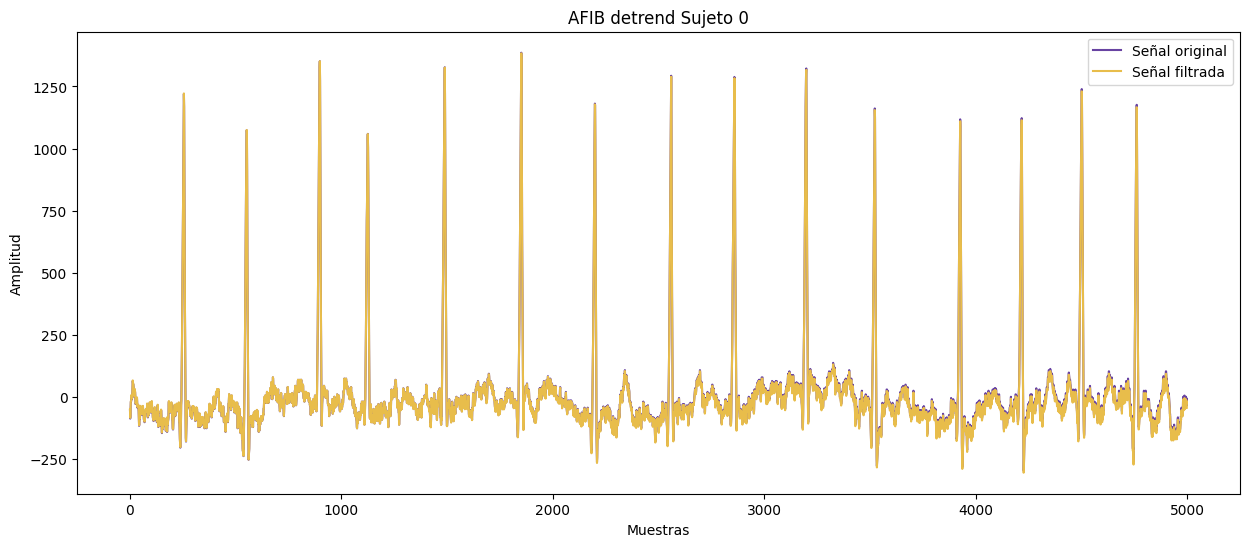

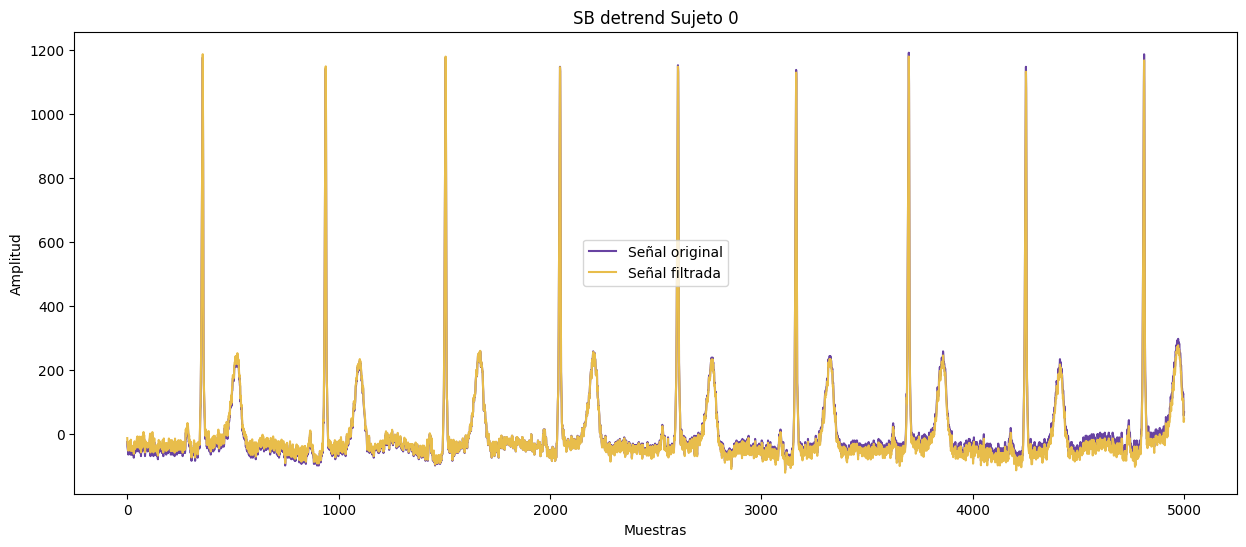

In [20]:
plt.figure(figsize=(15, 6))
plt.plot(datos_AFIB[0],label='Señal original',color='#6843A2')
plt.title('AFIB detrend Sujeto 0')
plt.legend()
plt.plot(detrend_AFIB_f2[0],label='Señal filtrada',color='#E8BD4B')
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()


plt.figure(figsize=(15, 6))
plt.plot(datos_SB[0],label='Señal original',color='#6843A2')
plt.title('SB detrend Sujeto 0')
plt.legend()
plt.plot(detrend_SB_f2[0],label='Señal filtrada',color='#E8BD4B')
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()

#### Wavelet modificado

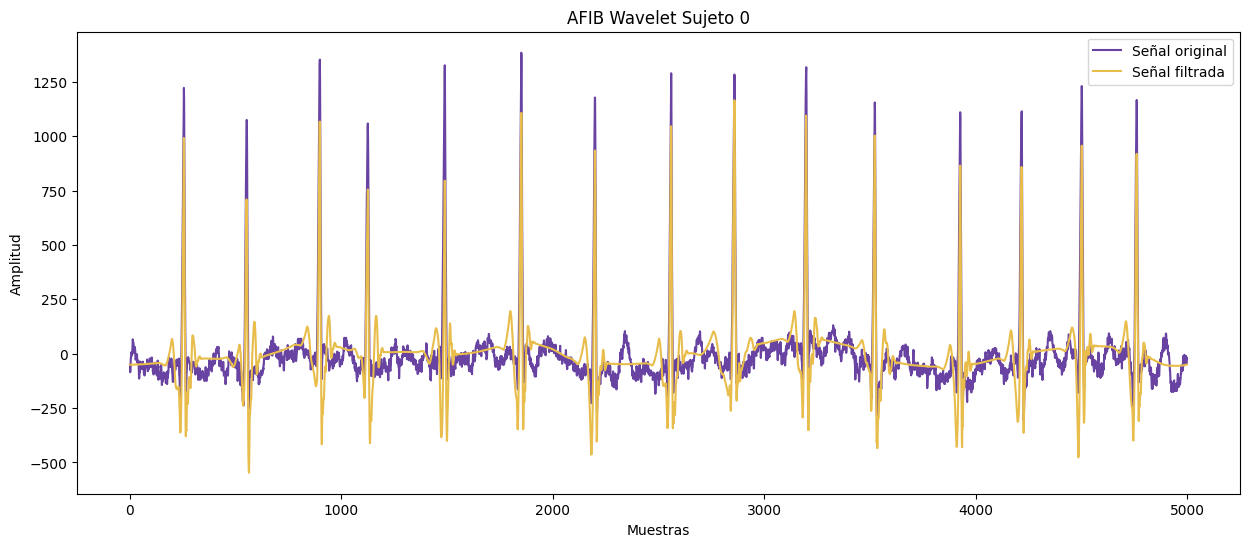

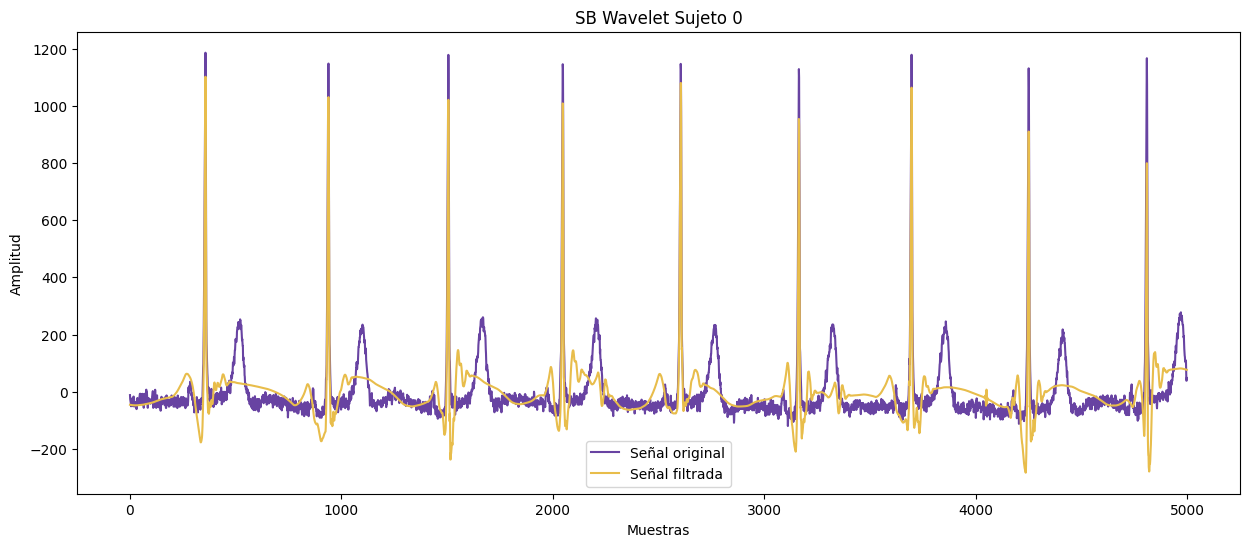

In [21]:
senal_reconstruida_AFIB_f2=wavelet_n(detrend_AFIB_f2)
senal_reconstruida_SB_f2=wavelet_n(detrend_SB_f2)

plt.figure(figsize=(15, 6))
plt.plot(detrend_AFIB_f2[0],label='Señal original',color='#6843A2')
plt.title('AFIB Wavelet Sujeto 0')
plt.legend()
plt.plot(senal_reconstruida_AFIB_f2[0],label='Señal filtrada',color='#E8BD4B')
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()


plt.figure(figsize=(15, 6))
plt.plot(detrend_SB_f2[0],label='Señal original',color='#6843A2')
plt.title('SB Wavelet Sujeto 0')
plt.legend()
plt.plot(senal_reconstruida_SB_f2[0],label='Señal filtrada',color='#E8BD4B')
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()

#### Filtrado pasabajas 50 Hz.

In [22]:
pasa_bajas_AFIB_flujo2=pasa_bajas_n(senal_reconstruida_AFIB_f2,6,Fs,50)
pasa_bajas_SB_flujo2=pasa_bajas_n(senal_reconstruida_SB_f2,6,Fs,50)

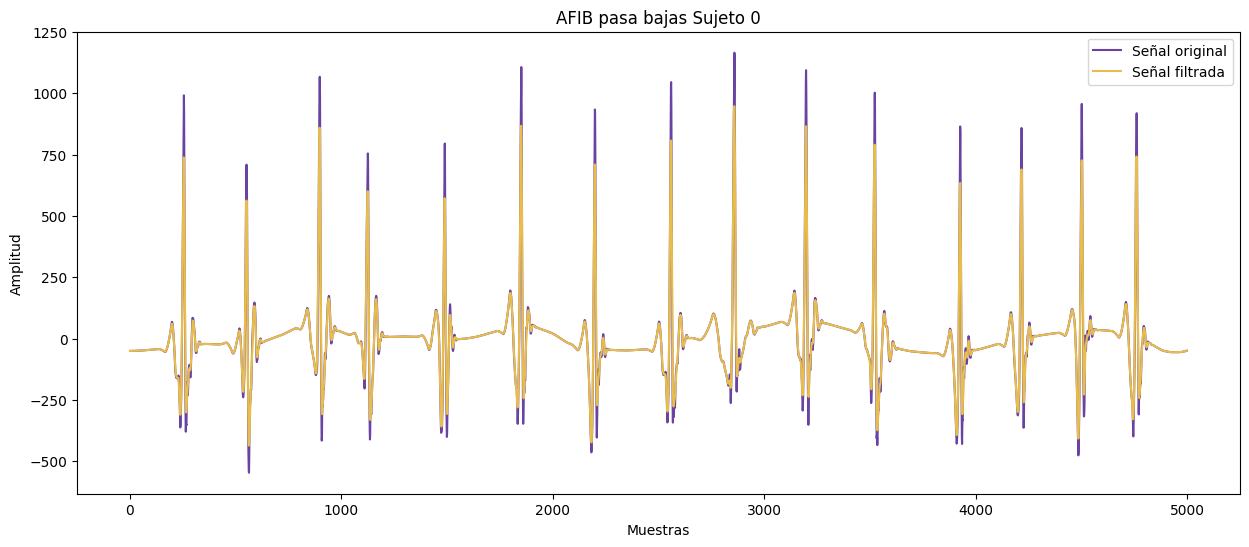

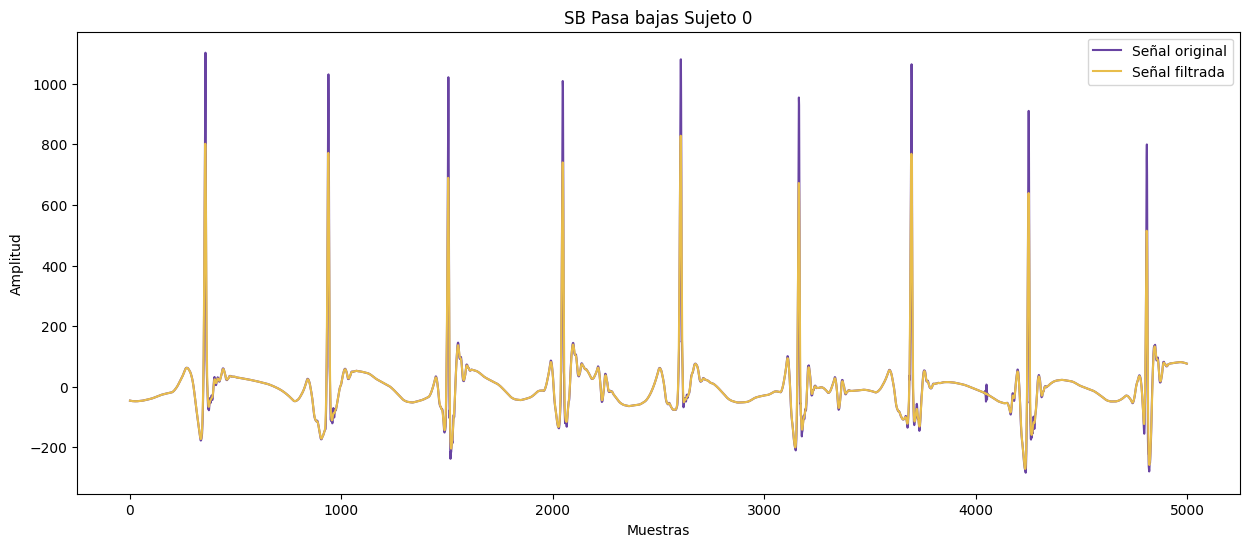

In [23]:
plt.figure(figsize=(15, 6))
plt.plot(senal_reconstruida_AFIB_f2[0],label='Señal original',color='#6843A2')
plt.title('AFIB pasa bajas Sujeto 0')
plt.legend()
plt.plot(pasa_bajas_AFIB_flujo2[0],label='Señal filtrada',color='#E8BD4B')
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.figure(figsize=(15, 6))
plt.plot(senal_reconstruida_SB_f2[0],label='Señal original',color='#6843A2')
plt.title('SB Pasa bajas Sujeto 0')
plt.legend()
plt.plot(pasa_bajas_SB_flujo2[0],label='Señal filtrada',color='#E8BD4B')
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()

### **Flujo 3**
* Filtro pasa-altas usando filtro IIR a 0.5 Hz. Justificar la elección de parámetros y si se usa FIR o IIR
* Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR     

Para ambos filtros se emplearon los mismos parámetros escogidos para el flujo 1, respectivamente

#### Filtro pasa altas IIR a 0.5 Hz

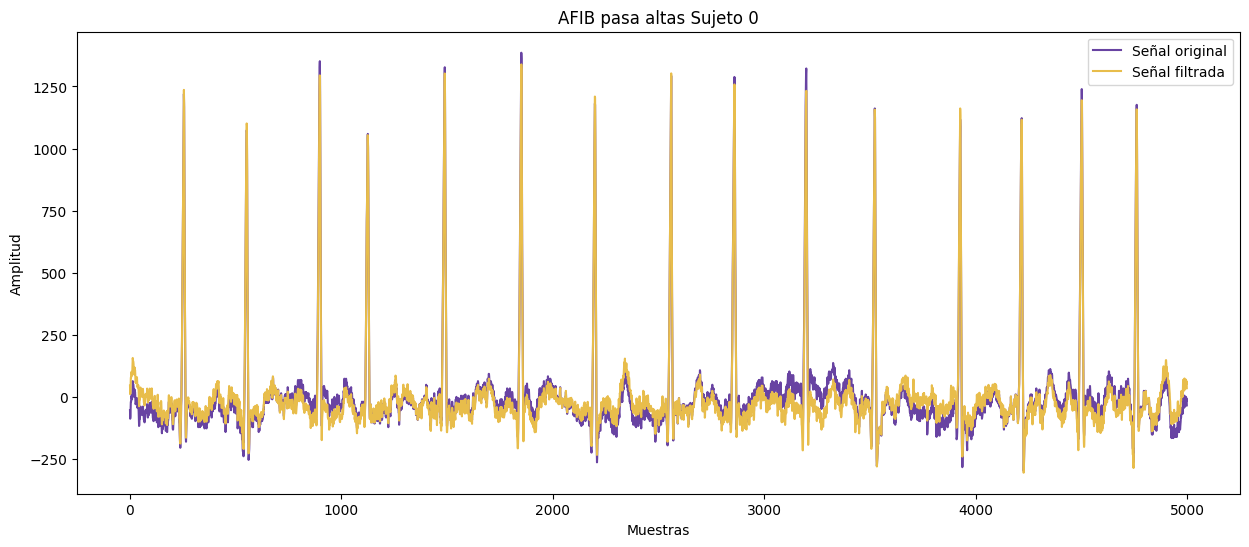

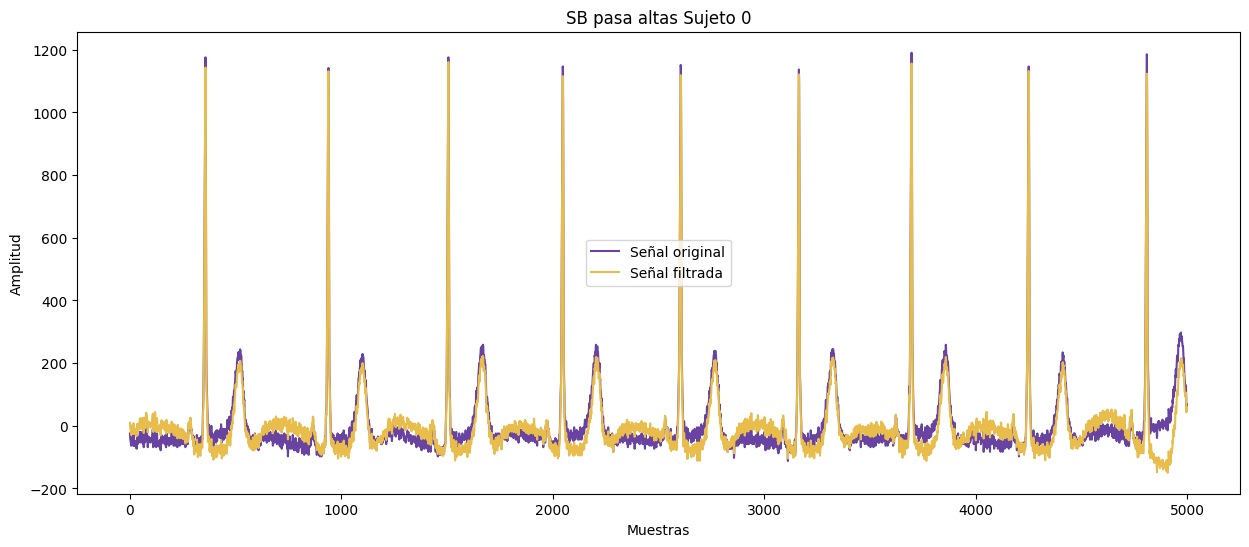

In [24]:
pasa_altas_AFIB_f3=pasa_altas(datos_AFIB,2,Fs,30,0.5)
pasa_altas_SB_f3=pasa_altas(datos_SB,2,Fs,30,0.5)

sujeto=0
plt.figure(figsize=(15, 6))
plt.plot(datos_AFIB[sujeto],label='Señal original',color='#6843A2')
plt.title(f'AFIB pasa altas Sujeto {sujeto}')
plt.legend()
plt.plot(pasa_altas_AFIB_f3[sujeto],label='Señal filtrada',color='#E8BD4B')
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()

plt.figure(figsize=(15, 6))
plt.plot(datos_SB[sujeto],label='Señal original',color='#6843A2')
plt.title(f'SB pasa altas Sujeto {sujeto}')
plt.legend()
plt.plot(pasa_altas_SB_f3[sujeto],label='Señal filtrada',color='#E8BD4B')
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()

#### Filtrado pasabajas 50 Hz.

Text(0, 0.5, 'Amplitud')

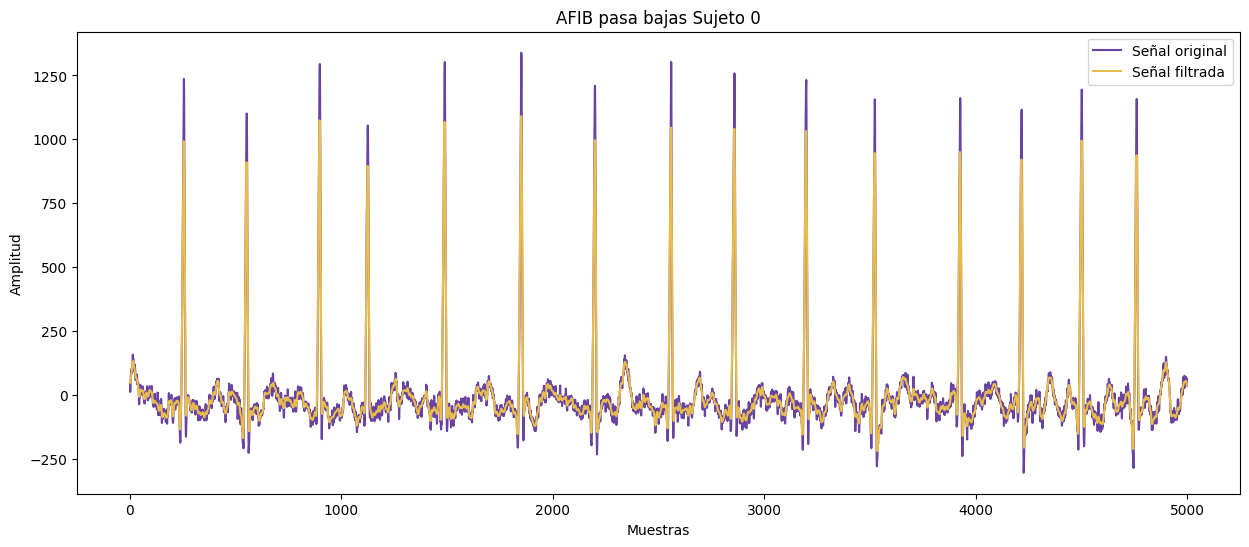

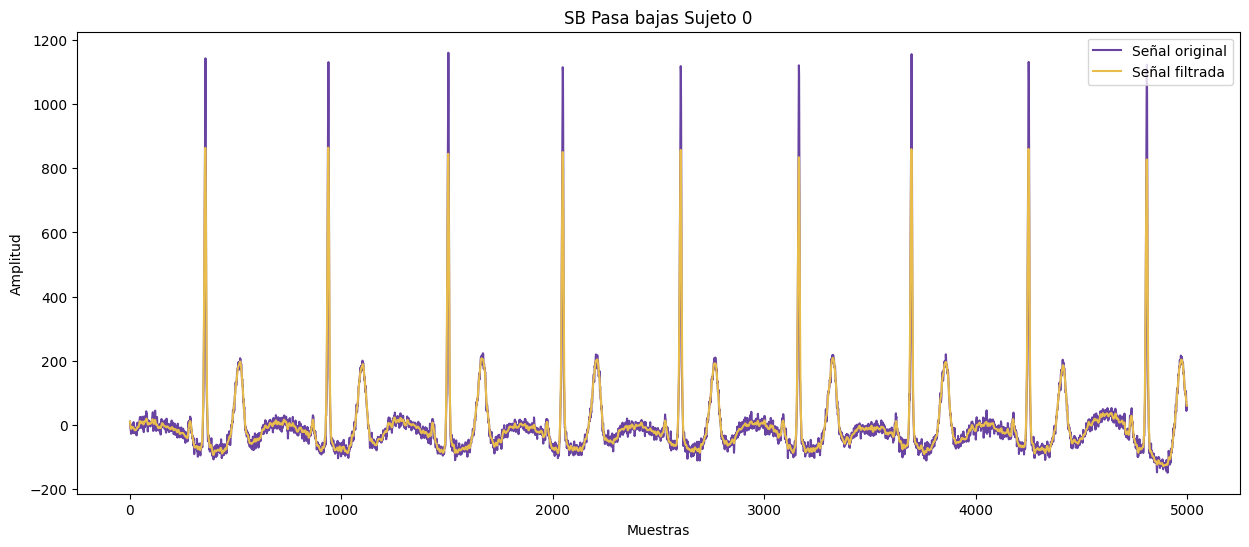

In [25]:
pasa_bajas_AFIB_flujo3=pasa_bajas_n(pasa_altas_AFIB_f3,6,Fs,50)
pasa_bajas_SB_flujo3=pasa_bajas_n(pasa_altas_SB_f3,6,Fs,50)

sujeto=0

plt.figure(figsize=(15, 6))
plt.plot(pasa_altas_AFIB_f3[sujeto],label='Señal original',color='#6843A2')
plt.title(f'AFIB pasa bajas Sujeto {sujeto}')
plt.legend()
plt.plot(pasa_bajas_AFIB_flujo3[sujeto],label='Señal filtrada',color='#E8BD4B')
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Amplitud')

plt.figure(figsize=(15, 6))
plt.plot(pasa_altas_SB_f3[sujeto],label='Señal original',color='#6843A2')
plt.title(f'SB Pasa bajas Sujeto {sujeto}')
plt.legend()
plt.plot(pasa_bajas_SB_flujo3[sujeto],label='Señal filtrada',color='#E8BD4B')
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Amplitud')

### Describir los resultados obtenidos y decidir si el resto del procesamiento se hace con el flujo 1, el flujo 2 o el flujo 3 (20%)


Text(0, 0.5, 'Amplitud')

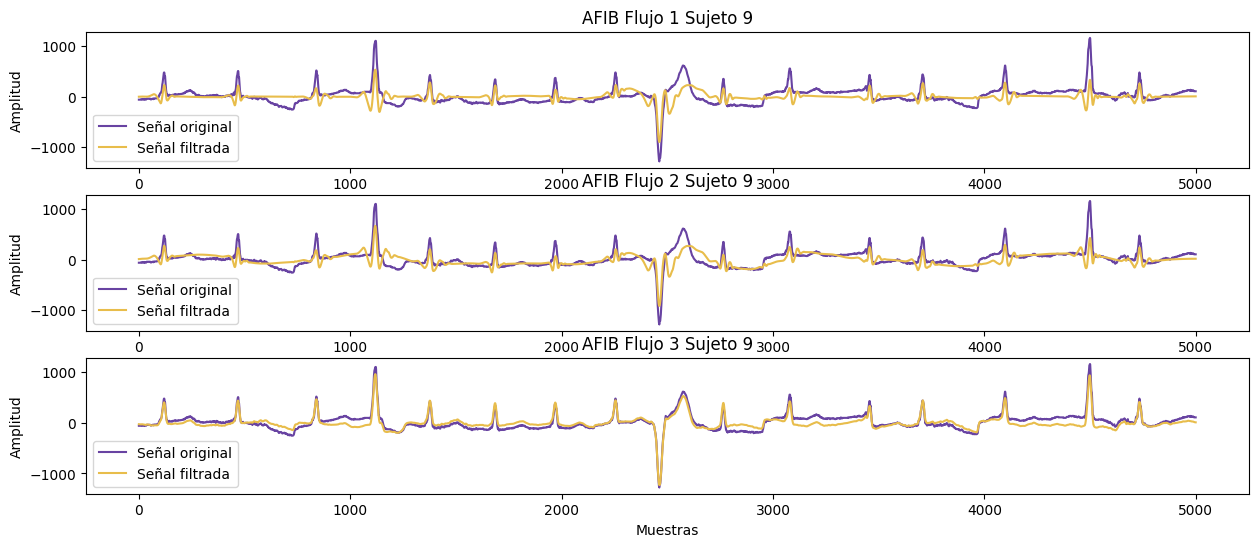

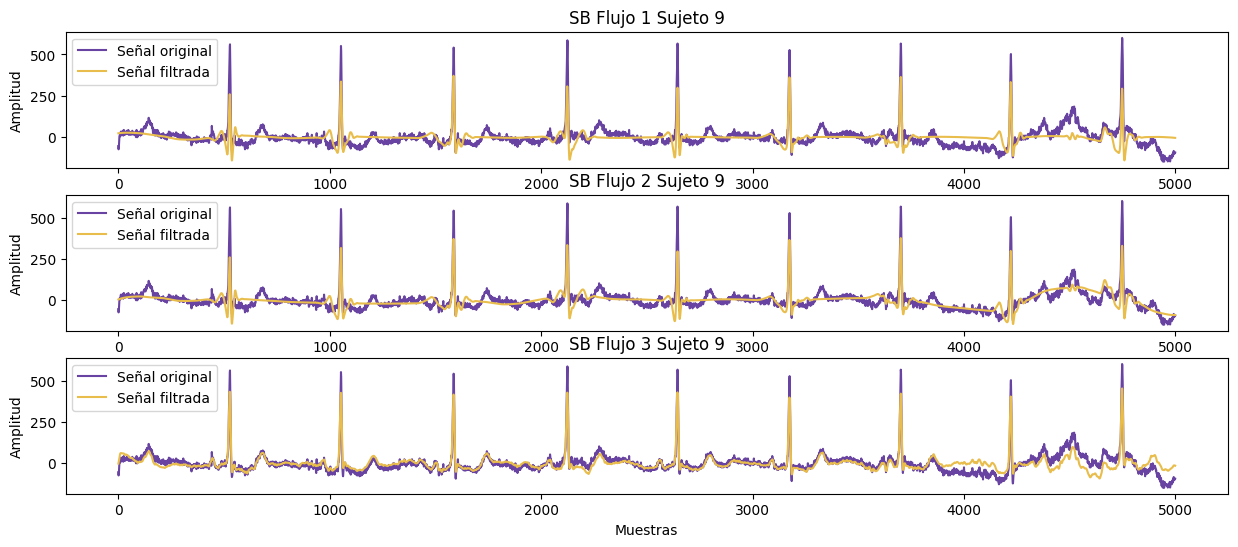

In [26]:
sujeto=9 #Cambiando el numero de sujeto 0-10
#AFIB
plt.figure(figsize=(15, 6))
plt.subplot( 3,1,1 ) #FLUJO 1
plt.plot(datos_AFIB[sujeto],label='Señal original',color='#6843A2')
plt.title(f'AFIB Flujo 1 Sujeto {sujeto}')
plt.legend()
plt.plot(pasa_bajas_AFIB_flujo1[sujeto],label='Señal filtrada',color='#E8BD4B')
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Amplitud')

plt.subplot( 3,1,2 ) #FLUJO 2
plt.plot(datos_AFIB[sujeto],label='Señal original',color='#6843A2')
plt.title(f'AFIB Flujo 2 Sujeto {sujeto}')
plt.legend()
plt.plot(pasa_bajas_AFIB_flujo2[sujeto],label='Señal filtrada',color='#E8BD4B')
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Amplitud')

plt.subplot( 3,1,3 ) #FLUJO 3
plt.plot(datos_AFIB[sujeto],label='Señal original',color='#6843A2')
plt.title(f'AFIB Flujo 3 Sujeto {sujeto}')
plt.legend()
plt.plot(pasa_bajas_AFIB_flujo3[sujeto],label='Señal filtrada',color='#E8BD4B')
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Amplitud')

#SB
plt.figure(figsize=(15, 6))
plt.subplot( 3,1,1 ) #FLUJO 1
plt.plot(datos_SB[sujeto],label='Señal original',color='#6843A2')
plt.title(f'SB Flujo 1 Sujeto {sujeto}')
plt.legend()
plt.plot(pasa_bajas_SB_flujo1[sujeto],label='Señal filtrada',color='#E8BD4B')
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Amplitud')

plt.subplot( 3,1,2 ) #FLUJO 2
plt.plot(datos_SB[sujeto],label='Señal original',color='#6843A2')
plt.title(f'SB Flujo 2 Sujeto {sujeto}')
plt.legend()
plt.plot(pasa_bajas_SB_flujo2[sujeto],label='Señal filtrada',color='#E8BD4B')
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Amplitud')

plt.subplot( 3,1,3 ) #FLUJO 3
plt.plot(datos_SB[sujeto],label='Señal original',color='#6843A2')
plt.title(f'SB Flujo 3 Sujeto {sujeto}')
plt.legend()
plt.plot(pasa_bajas_SB_flujo3[sujeto],label='Señal filtrada',color='#E8BD4B')
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Amplitud')

### Con el flujo seleccionado procesar las señales de la base de datos ECGData.zip derivación II. En este punto deberíamos estar en el mismo punto donde partimos en el proyecto 2, con señales filtradas.

Se escoge el flujo 1 debido a que es el que presenta las mejores características pues no presenta ruido entre los puntos T y P de la señal ECG, como sí se presenta en el flujo 3. Además, al realizar pasa altas se retiran las frecuencias bajas lo que disminuye el desfase de la línea base causada por movimientos esporádicos como movimientos del paciente que tiene frecuencias bajas en esta señal.

De igual forma, es el flujo que mejor se acopla para diferentes sujetos pues la línea base se mantiene centrada, a diferencia del flujo 2.  

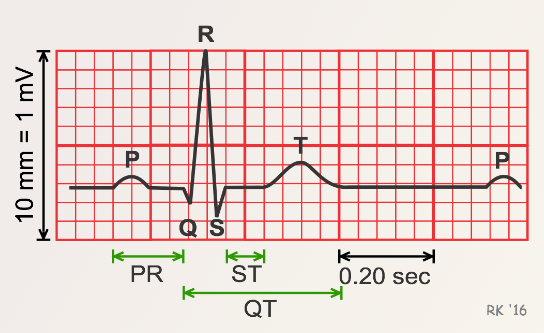

Imagen tomada de: “CV Physiology | Electrocardiogram (EKG, ECG)”. [En línea]. Disponible en: https://cvphysiology.com/arrhythmias/a009

### A las señales filtradas con el flujo seleccionado aplicar el procesamiento de normalización usado en el proyecto 2.

In [27]:
senales_AFIB_denoised=pasa_bajas_AFIB_flujo1
senales_SB_denoised=pasa_bajas_SB_flujo1

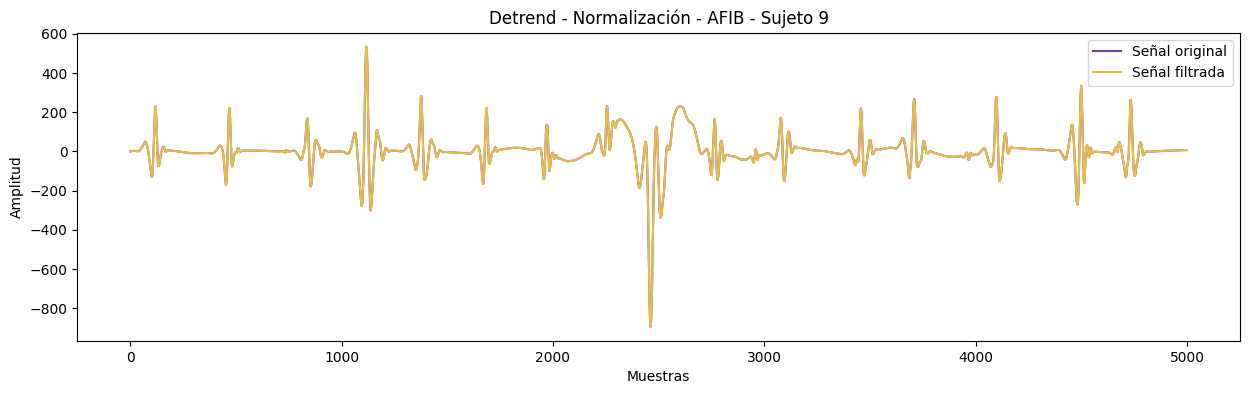

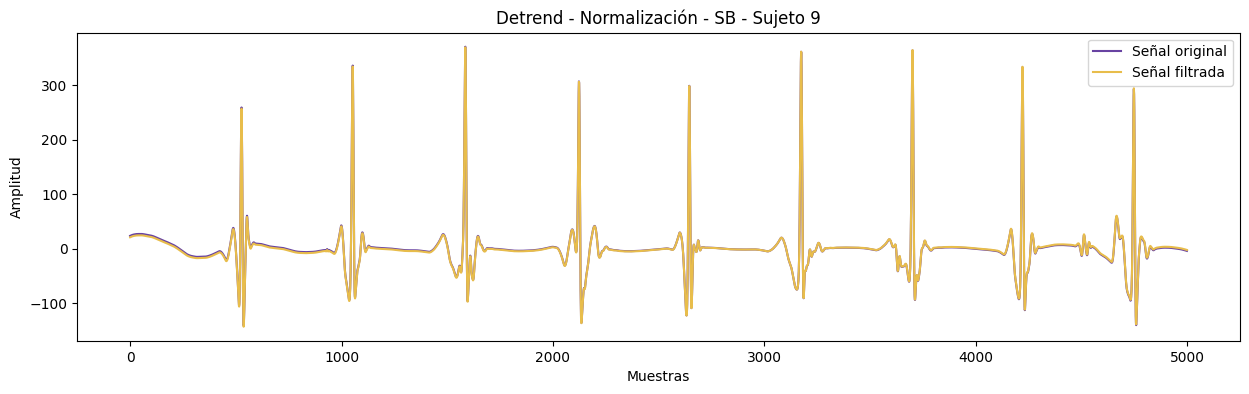

In [28]:
detrend_AFIB=detrend_n(senales_AFIB_denoised)
detrend_SB=detrend_n(senales_SB_denoised)

sujeto=9
plt.figure(figsize=(15, 4))
plt.plot(senales_AFIB_denoised[sujeto],label='Señal original',color='#6843A2')
plt.title(f'Detrend - Normalización - AFIB - Sujeto {sujeto}')
plt.legend()
plt.plot(detrend_AFIB[sujeto],label='Señal filtrada',color='#E8BD4B')
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()


plt.figure(figsize=(15, 4))
plt.plot(senales_SB_denoised[sujeto],label='Señal original',color='#6843A2')
plt.title(f'Detrend - Normalización - SB - Sujeto {sujeto}')
plt.legend()
plt.plot(detrend_SB[sujeto],label='Señal filtrada',color='#E8BD4B')
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()

#### Compresión

In [29]:
def compresion_n(senal):
  n=len(senal)
  x=len(senal[0])
  compresion=np.zeros((n,x))
  fila=0
  for item in senal:
      x_max=max(item)
      x_min=min(item)
      for i,valor in enumerate(item):
        comp=(valor-x_min)/(x_max-x_min)
        compresion[fila, i] = comp
      fila+=1
  fila2=0
  for i in compresion:
    det2=signal.detrend(i) #Como la señal se desfasa para dejarla en el rango de 0 y 1 se vuelve a aplicar detrend para que quede centrada en 0.
    compresion[fila2]=det2
    fila2+=1
  return compresion

Text(0, 0.5, 'Amplitud')

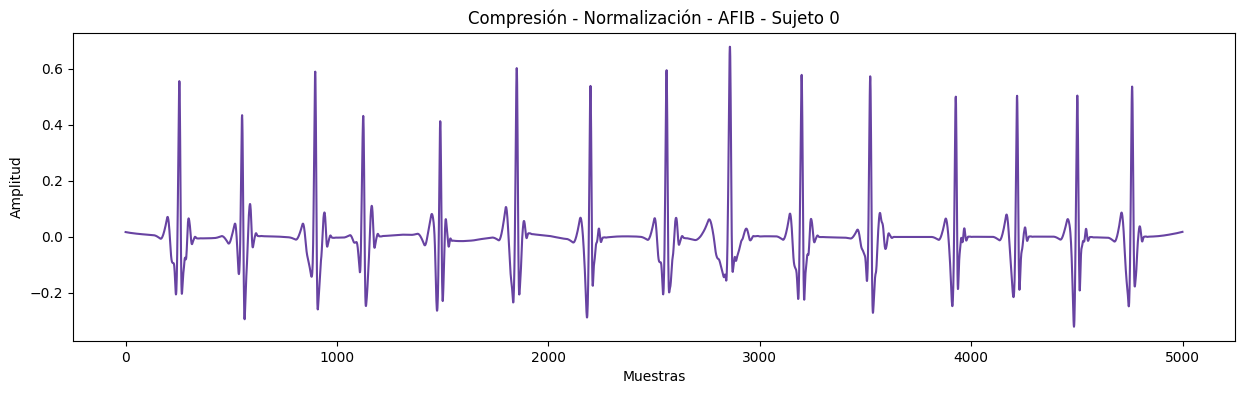

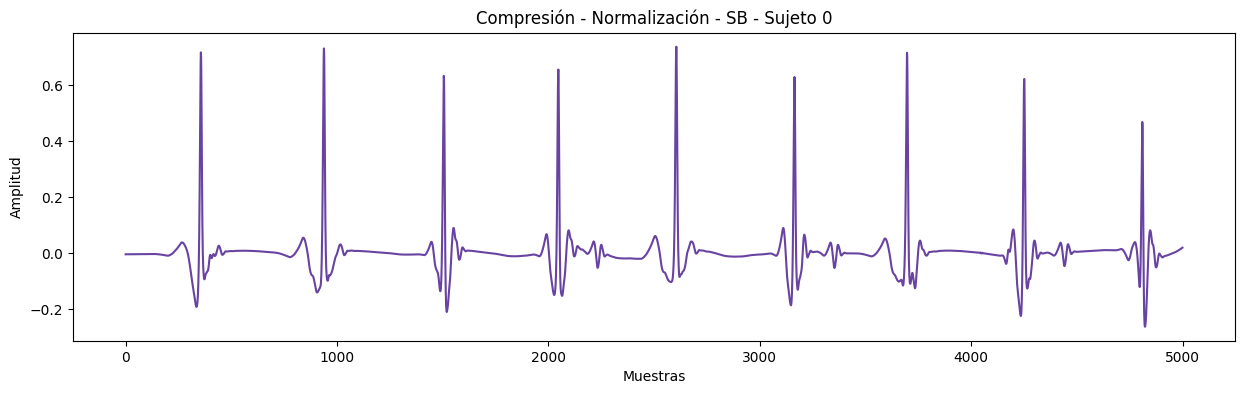

In [30]:
compresion_AFIB=compresion_n(detrend_AFIB)
compresion_SB=compresion_n(detrend_SB)

sujeto=0
plt.figure(figsize=(15, 4))
plt.title(f'Compresión - Normalización - AFIB - Sujeto {sujeto}')
plt.plot(compresion_AFIB[sujeto],color='#6843A2')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')

plt.figure(figsize=(15, 4))
plt.title(f'Compresión - Normalización - SB - Sujeto {sujeto}')
plt.plot(compresion_SB[sujeto],color='#6843A2')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')

In [31]:
print(senales_AFIB_denoised[0])
print(detrend_AFIB[0])
print(compresion_AFIB[0])

[24.55021023 24.34390455 24.13789342 ... 24.05009147 24.31121331
 24.57250137]
[23.38841015 23.1823145  22.97651341 ... 23.93784423 24.19917611
 24.4606742 ]
[0.01703664 0.01688652 0.01673661 ... 0.01743686 0.01762722 0.0178177 ]


## 5. Para cada señal extraer la frecuencia que contiene la máxima potencia usando Welch (15%)

In [32]:
def welch(senal,fs):
  n=len(senal[0])
  nperseg=n/4 #Ancho de la ventana (fracción de la longitud total del canal)
  noverlap = int(nperseg/2) #Solapamiento

  welch=list()

  for i in senal:
    f,Pxx = pwelch(i,fs,'hann',nperseg,noverlap)
    welch.append(Pxx)
  return welch,f

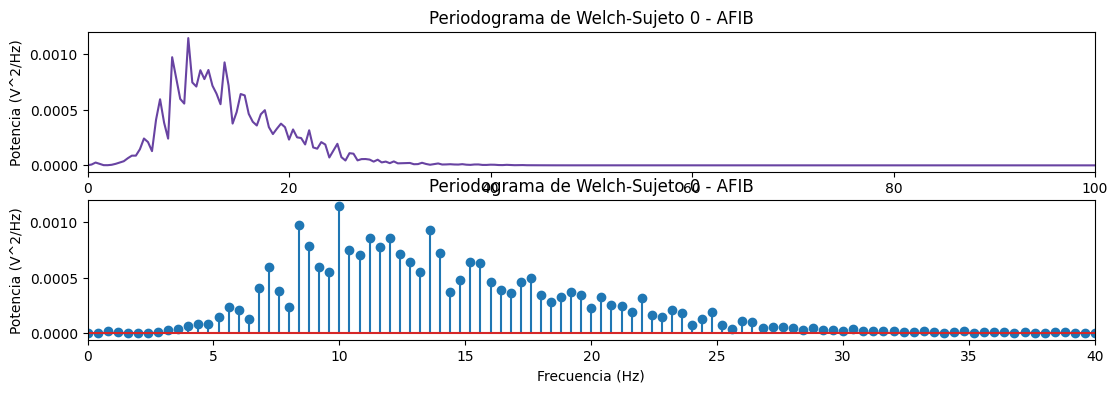

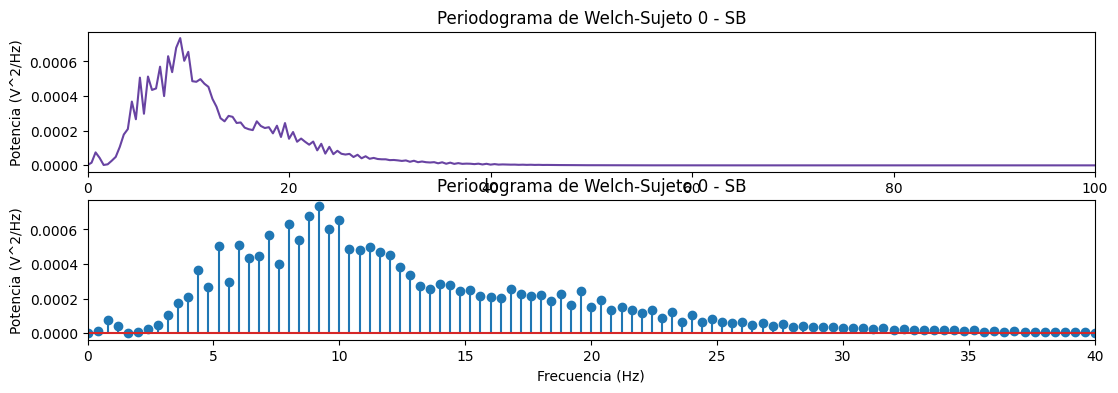

In [33]:
welch_AFIB,f=welch(compresion_AFIB,Fs)
welch_SB,f=welch(compresion_SB,Fs)
sujeto=0
#AFIB
plt.figure(figsize=(13, 4))
plt.subplot(2,1,1)
plt.plot(f,welch_AFIB[sujeto],color='#6843A2')
plt.title(f'Periodograma de Welch-Sujeto {sujeto} - AFIB')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Potencia (V^2/Hz)')
plt.xlim([0,100])

plt.subplot(2,1,2)
plt.stem(f, welch_AFIB[sujeto])
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Potencia (V^2/Hz)')
plt.xlim([0, 40])  # rango para el eje X
#plt.ylim([0, 0.003])  # rango para el eje y
plt.title(f'Periodograma de Welch-Sujeto {sujeto} - AFIB')
plt.show()

#SB
plt.figure(figsize=(13, 4))
plt.subplot(2,1,1)
plt.plot(f,welch_SB[sujeto],color='#6843A2')
plt.title(f'Periodograma de Welch-Sujeto {sujeto} - SB')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Potencia (V^2/Hz)')
plt.xlim([0,100])

plt.subplot(2,1,2)
plt.stem(f, welch_SB[sujeto])
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Potencia (V^2/Hz)')
plt.xlim([0, 40])  # rango para el eje X
#plt.ylim([0, 0.002])  # rango para el eje y
plt.title(f'Periodograma de Welch-Sujeto {sujeto} - SB')
plt.show()

In [34]:
def fMP(senal,f):
  max_potencia = np.zeros(len(senal), dtype=int)
  frecuencia = np.zeros(len(senal))
  for i in range(len(senal)):
    max_potencia[i] = np.argmax(np.abs(senal[i][:]))
    frecuencia[i] = f[:][max_potencia[i]]
  return frecuencia

In [35]:
frecuencia_AFIB=fMP(welch_AFIB,f)
frecuencia_SB=fMP(welch_SB,f)

tablita_frec_AFIB=pd.DataFrame(frecuencia_AFIB)
print(pd.DataFrame(frecuencia_AFIB))

tablita_frec_SB=pd.DataFrame(frecuencia_SB)
print(pd.DataFrame(frecuencia_SB))

      0
0  10.0
1  10.4
2  10.8
3   9.6
4   4.0
5  10.4
6   9.2
7  10.4
8  13.6
9   1.6
      0
0   9.2
1  11.6
2  12.4
3  14.8
4   9.6
5  11.6
6  10.0
7   9.2
8   7.2
9  10.4


## 6. Crear una rutina que aplique sobre todos los archivos de la base de datos las rutina 3 al 5 y almacene los resultados en un dataframe donde se pueda registro, tipo de patología y el frecuencia de máxima potencia (fMP)

In [36]:
#Flujo 1
senal_completa_AFIB_pasa_altas=pasa_altas(derivacion_AFIB,2,Fs,30,0.5)
senal_completa_SB_pasa_altas=pasa_altas(derivacion_SB,2,Fs,30,0.5)

#Flujo
senal_completa_AFIB_wavelet=wavelet_n(senal_completa_AFIB_pasa_altas)
senal_completa_SB_wavelet=wavelet_n(senal_completa_SB_pasa_altas)
senal_completa_AFIB_pasa_bajas=pasa_bajas_n(senal_completa_AFIB_wavelet,6,Fs,50)
senal_completa_SB_pasa_bajas=pasa_bajas_n(senal_completa_SB_wavelet,6,Fs,50)

#Normalización
senal_completa_AFIB_detrend_n=detrend_n(senal_completa_AFIB_pasa_bajas)
senal_completa_SB_detrend_n=detrend_n(senal_completa_SB_pasa_bajas)
senal_completa_AFIB_compresion=compresion_n(senal_completa_AFIB_detrend_n)
senal_completa_SB_compresion=compresion_n(senal_completa_SB_detrend_n)

#Welch
welch_AFIB_completa,f=welch(senal_completa_AFIB_compresion,Fs)
welch_SB_completa,f=welch(senal_completa_SB_compresion,Fs)

#fMP
frecuencia_AFIB_completa=fMP(welch_AFIB_completa,f)
frecuencia_SB_completa=fMP(welch_SB_completa,f)

In [37]:
tablita_frec_AFIB=pd.DataFrame(frecuencia_AFIB_completa)
print(pd.DataFrame(frecuencia_AFIB_completa))

tablita_frec_SB=pd.DataFrame(frecuencia_SB_completa)
print(pd.DataFrame(frecuencia_SB_completa))

         0
0     10.0
1     10.4
2     10.8
3      9.6
4      4.0
...    ...
1775  10.8
1776   1.6
1777  10.0
1778  10.8
1779  14.8

[1780 rows x 1 columns]
         0
0      9.2
1     11.6
2     12.4
3     14.8
4      9.6
...    ...
3884   1.2
3885   7.6
3886   6.4
3887  13.2
3888   9.6

[3889 rows x 1 columns]


In [38]:
tablita_nombres_AFIB=pd.DataFrame(nombres_AFIB)
tablita_nombres_SB=pd.DataFrame(nombres_SB)

#AFIB

df_concat_AFIB = pd.concat([tablita_nombres_AFIB[:]], axis=1)
df_concat_AFIB['Patología'] = 'AFIB'
df_concat_AFIB['fMP'] = tablita_frec_AFIB

df_concat_AFIB.columns = ['Registro','Patología','fMP']

print(df_concat_AFIB)

#SB
df_concat_SB = pd.concat([tablita_nombres_SB[:]], axis=1)
df_concat_SB['Patología'] = 'SB'
df_concat_SB['fMP'] = tablita_frec_SB

df_concat_SB.columns = ['Registro','Patología','fMP']

print('\n',df_concat_SB)

with pd.ExcelWriter('datos_fMP.xlsx', engine='openpyxl') as writer:
    df_concat_AFIB.to_excel(writer, sheet_name='AFIB', index=True)
    df_concat_SB.to_excel(writer, sheet_name='SB', index=True)


                        Registro Patología   fMP
0     MUSE_20180113_171327_27000      AFIB  10.0
1     MUSE_20180114_075026_69000      AFIB  10.4
2     MUSE_20180113_133901_16000      AFIB  10.8
3     MUSE_20180116_123940_90000      AFIB   9.6
4     MUSE_20180114_075003_61000      AFIB   4.0
...                          ...       ...   ...
1775  MUSE_20180116_120939_86000      AFIB  10.8
1776  MUSE_20180114_134126_54000      AFIB   1.6
1777  MUSE_20180115_131040_20000      AFIB  10.0
1778  MUSE_20180116_170450_55000      AFIB  10.8
1779  MUSE_20180115_131524_93000      AFIB  14.8

[1780 rows x 3 columns]

                         Registro Patología   fMP
0     MUSE_20180112_073319_29000        SB   9.2
1     MUSE_20180113_121940_44000        SB  11.6
2     MUSE_20180112_120347_79000        SB  12.4
3     MUSE_20180114_075128_92000        SB  14.8
4     MUSE_20180118_174026_42000        SB   9.6
...                          ...       ...   ...
3884  MUSE_20180114_070348_17000        SB

## 7. Comparar los resultados de fMP del proyecto 3 con los del proyecto 2 usando estadística descriptiva: gráficos y pruebas de hipótesis (15%) Discuta si hay más diferencias entre los tipos de señales con el flujo de procesamiento propuesto respecto al que se trabajó en el proyecto 2

In [39]:
# Importación de los datos del proyecto 2

# Para AFIB
df_AFIB = pd.read_excel('/content/drive/MyDrive/ColabNotebooks/Biosenales/datos_procesados.xlsx',sheet_name='Datos_AFIB')
print(np.shape(df_AFIB))
fMP_AFIB=df_AFIB['fMP']
#Para SB
df_SB = pd.read_excel('/content/drive/MyDrive/ColabNotebooks/Biosenales/datos_procesados.xlsx',sheet_name='Datos_SB')
print(np.shape(df_SB))
fMP_SB=df_SB['fMP']

(1780, 5)
(3889, 5)


### Estadística descriptiva

In [40]:

# Para AFIB
df_AFIB = pd.read_excel('/content/datos_fMP.xlsx',sheet_name='AFIB')
print(np.shape(df_AFIB))
fMP_AFIB_n=df_AFIB['fMP']
#Para SB
df_SB = pd.read_excel('/content/datos_fMP.xlsx',sheet_name='SB')
print(np.shape(df_SB))
fMP_SB_n=df_SB['fMP']

(1780, 4)
(3889, 4)


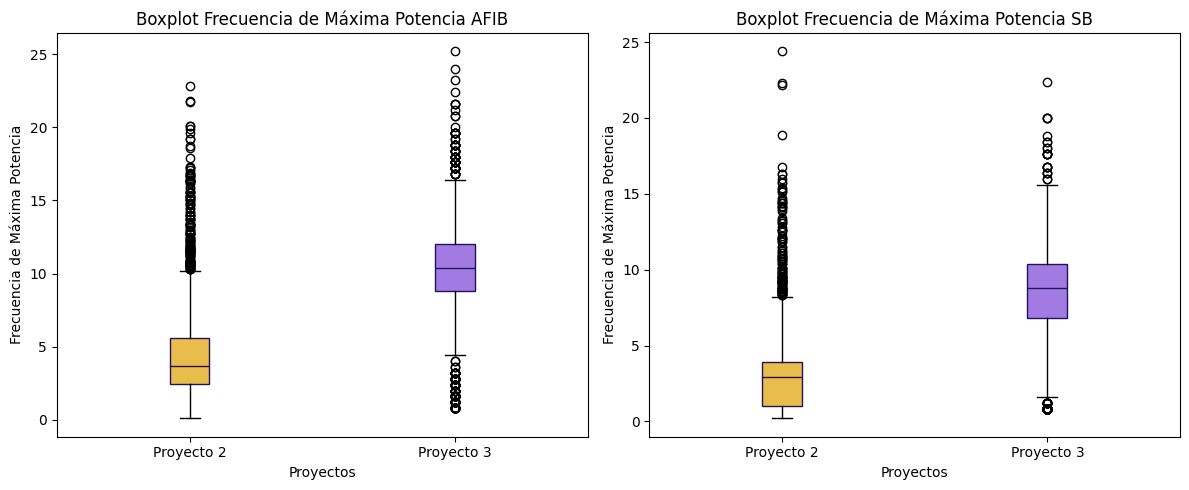

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot para 'AFIB'
#data_fMP = [fMP_AFIB[:], fMP_AFIB_n[:]]
axs[0].boxplot(fMP_AFIB, patch_artist=True,
                boxprops=dict(facecolor='#E8BD4B',edgecolor='#23115F'), medianprops=dict(color='#23115F'), positions=[1])  # Proyecto 2
axs[0].boxplot(fMP_AFIB_n, patch_artist=True,
                boxprops=dict(facecolor='#A27BE2',edgecolor='#23115F'), medianprops=dict(color='#23115F'), positions=[2])  # Proyecto 3
axs[0].set_title('Boxplot Frecuencia de Máxima Potencia AFIB')
axs[0].set_xlabel('Proyectos')
axs[0].set_ylabel('Frecuencia de Máxima Potencia')
axs[0].set_xticks([1, 2])
axs[0].set_xticklabels(['Proyecto 2', 'Proyecto 3'])

# Boxplot para 'SB'
#data_fMP_SB = [fMP_SB[:], fMP_SB_n[:]]
axs[1].boxplot(fMP_SB, patch_artist=True,
                boxprops=dict(facecolor='#E8BD4B',edgecolor='#23115F'), medianprops=dict(color='#23115F'), positions=[1])  # Proyecto 2
axs[1].boxplot(fMP_SB_n, patch_artist=True,
                boxprops=dict(facecolor='#A27BE2',edgecolor='#23115F'), medianprops=dict(color='#23115F'), positions=[2])  # Proyecto 3
axs[1].set_title('Boxplot Frecuencia de Máxima Potencia SB')
axs[1].set_xlabel('Proyectos')
axs[1].set_ylabel('Frecuencia de Máxima Potencia')
axs[1].set_xticks([1, 2])
axs[1].set_xticklabels(['Proyecto 2', 'Proyecto 3'])
plt.tight_layout()

plt.show()

En la fibrilación auricular (AFIB) las aurículas y los ventrículos no trabajan de manera sincronizada por tal motivo puede haber menos energía concentrada en las frecuencias más bajas, ya que la actividad es más rápida y desorganizada. En cambio, en la bradicardia sinusal (SB), se observará una mayor concentración de energía en las frecuencias bajas, lo que indica un ritmo cardíaco más lento y regular.    

Las definiciones anteriores se pueden evidenciar en ambos proyectos, ya que como se observa para la AFIB se encontró que su máxima potencia se encuentra en frecuencias más altas a comparación de la SB, esto ayuda a comprender que las señales se encuentran bien clasificadas y que la información hallada corresponde de manera correcta a la definición morfológica. Adicionalmente, esto evidencia que no hay una diferencia significativa entre los tipos de señales a las cuales se les aplicó el flujo 1 (proyecto 3) respecto a las del proyecto 2.

A pesar de que en ambos proyectos se evidencia lo anterior, en el proyecto 3 para ambas enfermedades se ve un aumento en el valor de las frecuencias que tienen la máxima potencia. Igualmente, en este proyecto se observa que hay menos valores atípicos con respecto al proyecto 2, lo cual corresponde a que puede a ver un mejor filtrado de la señal, ya que este, al eliminar el ruido, hace que los datos sean más homogéneos.   

Por otro lado, en el proyecto 2 en el extremo inferior de la caja se evidencia un bigote de menor tamaño, lo cual podría indicar que los datos están menos dispersos con respecto a los datos filtrados en el proyecto 3.


### Hipótesis
*   **Normalidad**

H0: El grupo tiene una distribución normal

H1: El grupo no tiene distribución normal

*   **Homocedasticidad**

H0: Los grupos tienen varianzas iguales

H1: Los grupos tienen varianzas diferentes
*   **Independencia**

Se asume independencia de los grupos

Se toma un α=0.05

### Supuesto de normalidad
Al tener tanta cantidad de datos (n>50) se aplica Kolmogorov Smirnov

In [42]:
kf_A, pf_A = sis.kstest(fMP_AFIB,'norm')
kf_S, pf_S = sis.kstest(fMP_SB,'norm')
ks_A, pf_A_n = sis.kstest(fMP_AFIB_n,'norm')
ks_S, pf_S_n = sis.kstest(fMP_SB_n,'norm')

kolmo=pd.DataFrame(np.array([pf_A,pf_S,pf_A_n,pf_S_n]))
filas=pd.DataFrame(np.array(['fMP AFIB P2','fMP SB P2','fMP AFIB P3','fMP SB P3']))
e = pd.concat([filas,kolmo], axis=1)
e.columns = ['Datos',' Valor p - Kolmogorov']
print(f'Donde P2 = Proyecto 2 y P3 = Proyecto 3 \n {e} ')

Donde P2 = Proyecto 2 y P3 = Proyecto 3 
          Datos   Valor p - Kolmogorov
0  fMP AFIB P2                    0.0
1    fMP SB P2                    0.0
2  fMP AFIB P3                    0.0
3    fMP SB P3                    0.0 


In [43]:
#levene - homocedasticidad
homoces_fMP, p_fMP = sis.levene(fMP_AFIB,fMP_AFIB_n)
homoces_fMP_n, p_fMP_SB = sis.levene(fMP_SB,fMP_SB_n)

h=pd.DataFrame(np.array([p_fMP,p_fMP_SB]))
rows=pd.DataFrame(np.array(['fMP AFIB (P2) - fMP AFIB (P3)','fMP SB (P2)- fMP SB (P3)']))
lev = pd.concat([rows,h], axis=1)
lev.columns = ['Datos',' Valor p - Lèvene']
print(f' P2 = Proyecto 2 \n P3 = Proyecto 3 \n {lev}')

 P2 = Proyecto 2 
 P3 = Proyecto 3 
                            Datos   Valor p - Lèvene
0  fMP AFIB (P2) - fMP AFIB (P3)       3.877789e-06
1       fMP SB (P2)- fMP SB (P3)       1.077803e-65


Todas las hipótesis se rechazan, por lo tanto, no tienen distribución normal y presentan varianzas diferentes.

Debido al no cumplimiento de los suspuestos se aplica prueba no paramétrica:

**Prueba no paramétrica - U Mann Whitney**

*   H0: No hay diferencia (en términos de tendencia central) entre los dos grupos de la población.
*   H1: Existe una diferencia (con respecto a la tendencia central) entre los dos grupos de la población

In [44]:
valor_m, p_fMP_m = sis.mannwhitneyu(fMP_AFIB,fMP_AFIB_n)
valor_m, p_fMP_sm = sis.mannwhitneyu(fMP_SB,fMP_SB_n)

u=pd.DataFrame(np.array([p_fMP_m,p_fMP_sm]))
rows=pd.DataFrame(np.array(['fMP AFIB (P2) - fMP AFIB (P3)','fMP SB (P2) - fMP SB (P3)']))
um = pd.concat([rows,u], axis=1)
um.columns = ['Datos',' Valor p - U Mann Whitney']
print(f' P2 = Proyecto 2 \n P3 = Proyecto 3 \n {um} ')

 P2 = Proyecto 2 
 P3 = Proyecto 3 
                            Datos   Valor p - U Mann Whitney
0  fMP AFIB (P2) - fMP AFIB (P3)              1.493519e-253
1      fMP SB (P2) - fMP SB (P3)               0.000000e+00 


Se rechaza la hipótesis nula, por lo cual se concluye que existe una diferencia significativa entre ambos datos de las señales. Por lo cual se puede decir que el filtrado esta influyendo de diferente manera en los grupos.

### **Conclusiones**

* Para la eliminación de ruido por medio del filtro de medias no locales (NLM) es importante tener en cuenta el parámetro de control de suavidad (h) y el tamaño del parche de muestras, ya que con el primer parámetro a mayor valor se produce un mejor suavizado y con el segundo parámetro si se utiliza un parche de menor tamaño se logra una mejor captura de los detalles locales.   
* El filtro wavelet Daubechie otorga resultados óptimos a comparación de otros filtros wavelet en el filtrado de señales ECG, debido a que no son simétricos como las ECG y presentan una forma de onda muy parecida al complejo PQRST.   
* El filtro tipo FIR seleccionado para el diseño de filtros pasabajas, permite preservar la integridad de la señal debido a que no presenta distorsión en fase.



### **Referencias**

[1]J. Zheng, J. Zhang, S. Danioko, H. Yao, H. Guo, y C. Rakovski, “A 12-lead electrocardiogram database for arrhythmia research covering more than 10,000 patients”, Sci. Data, vol. 7, núm. 1, p. 48, feb. 2020, doi: 10.1038/s41597-020-0386-x.

[2]	J. Zheng et al., “Optimal Multi-Stage Arrhythmia Classification Approach”, Sci. Rep., vol. 10, núm. 1, p. 2898, feb. 2020, doi: 10.1038/s41598-020-59821-7.   

[3] R. Singh, R. Mehta, y N. Rajpal, “Efficient wavelet families for ECG classification using neural classifiers”, Procedia Comput. Sci., vol. 132, pp. 11–21, ene. 2018, doi: 10.1016/j.procs.2018.05.054.

[4] H. Telangore, V. Azad, M. Sharma, A. Bhurane, R. S. Tan, y U. R. Acharya, “Early prediction of sudden cardiac death using multimodal fusion of ECG Features extracted from Hilbert–Huang and wavelet transforms with explainable vision transformer and CNN models”, Comput. Methods Programs Biomed., vol. 257, p. 108455, dic. 2024, doi: 10.1016/j.cmpb.2024.108455.

[5]D. M. Ballesteros, C. A. Lemus, y A. S. Lopez, “Compresion De Señales Ecg Utilizando Dwt Y Codificacion Huffman”, Sci. Tech., vol. XV, núm. 41, pp. 340–345, 2009.

[6]J. Yadav, N. Rajpal, y P. Vishwakarma, “Face recognition using Symlet, PCA and cosine angle distance measure”, ago. 2016, pp. 1–7. doi: 10.1109/IC3.2016.7880231.   

[7] A. Azzouz et al., «An efficient ECG signals denoising technique based on the combination of particle swarm optimisation and wavelet transform», Heliyon, vol. 10, n.o 5, p. e26171, mar. 2024, doi: 10.1016/j.heliyon.2024.e26171.

[8] R. B. Mabel, R. D. Ricardo, y R. L. Leonardo, “Compresión de señales de ECG mediante transformada wavelet con algoritmo MSPITH-1D”, en IV Latin American Congress on Biomedical Engineering 2007, Bioengineering Solutions for Latin America Health, C. Müller-Karger, S. Wong, y A. La Cruz, Eds., Berlin, Heidelberg: Springer, 2008, pp. 9–12. doi: 10.1007/978-3-540-74471-9_3.   

[9] N. Das and M. Chakraborty, "Performance analysis of FIR and IIR filters for ECG signal denoising based on SNR," 2017 Third International Conference on Research in Computational Intelligence and Communication Networks (ICRCICN), Kolkata, India, 2017, pp. 90-97, doi: 10.1109/ICRCICN.2017.8234487.

[10] S. Luo y P. Johnston, “A review of electrocardiogram filtering”, J. Electrocardiol., vol. 43, núm. 6, pp. 486–496, nov. 2010, doi: 10.1016/j.jelectrocard.2010.07.007.

